# Анализ данных
Построим модели по предсказанию уровня доходов в стране по показателям производительности сети.

## Setup
Оптимизируем дальнейший код и сразу заполним пространство всем необходимым функционалом.

In [1]:
import os
import logging

import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns

2023-05-31 19:36:50.284160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S',
                    force = True)


def check_folder(name: str) -> str:
    """If folder not exists - create, after return path"""

    if not os.path.exists(name):
        os.makedirs(name)

    return name

In [3]:
DATA_TYPE = 'light'
SERIAL_TYPE = 'fixed'

SEED = 0  # to reproduce building
BATCH_SIZE = 32

FIG_SIZE = (38.4,21.6)  # 3810x2160

DATA_PATH = f'data/{DATA_TYPE}'
LOGS_PATH = check_folder(f'logs/{DATA_TYPE}/{SERIAL_TYPE}')
MODEL_PATH = check_folder(f'model/{DATA_TYPE}/{SERIAL_TYPE}')
VISUAL_PATH = check_folder(f'visual/model/{DATA_TYPE}/{SERIAL_TYPE}')

In [4]:
sns.set_theme(palette='winter', font='jost', font_scale=3, rc={'figure.figsize': FIG_SIZE})

## Prepare
Загрузим датасет, отсортируем значения по годам и уровню доходов, уберём лишние признаки.

In [5]:
df = pd.read_csv(f'{DATA_PATH}/{SERIAL_TYPE}/{SERIAL_TYPE}_{DATA_TYPE}.csv').sort_values(by=['year', 'income'])
display(df)

,iso_a3,year,label,income,group,continent,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
728,VEN,2019,Venezuela,84.341,Low income,South America,2488.000000,746.250,147.00000,433441,102768
756,ZWE,2019,Zimbabwe,369.445,Low income,Africa,7779.750000,4636.625,26.50000,20461,7358
44,BDI,2019,Burundi,745.617,Low income,Africa,7248.500000,7556.250,27.00000,2272,727
112,CAF,2019,Central African Republic,1005.373,Low income,Africa,1071.500000,1191.875,401.58333,159,85
140,COD,2019,"Congo, Dem. Rep. of the",1112.838,Low income,Africa,4380.250000,3332.000,97.50000,6622,2257
...,...,...,...,...,...,...,...,...,...,...,...
123,CHE,2022,Switzerland,82274.856,High income,Europe,132038.333333,55715.250,9.50000,1466321,487125
571,QAT,2022,Qatar,108635.329,High income,Asia,120882.500000,66901.375,5.00000,481555,148771
599,SGP,2022,Singapore,119778.223,High income,Asia,247958.250000,215361.125,5.00000,1341188,346677
315,IRL,2022,Ireland,123764.551,High income,Europe,57344.750000,21281.000,14.00000,2059443,556629


Сбалансируем датасет, приведя группы к единому размеру и сократив его до 200 000 наблюдений на группу:

In [6]:
# df = pd.concat([df_group[1].sample(n=50_000, random_state=SEED) for df_group in df.groupby(['group', 'year'], sort=False)])
df.groupby('group').describe().round(2).T

group              High income  Low income  Lower-middle income   
year       count  1.920000e+02      192.00               184.00  \
           mean   2.020500e+03     2020.50              2020.50   
           std    1.120000e+00        1.12                 1.12   
           min    2.019000e+03     2019.00              2019.00   
           25%    2.019750e+03     2019.75              2019.75   
           50%    2.020500e+03     2020.50              2020.50   
           75%    2.021250e+03     2021.25              2021.25   
           max    2.022000e+03     2022.00              2022.00   
income     count  1.920000e+02      192.00               184.00   
           mean   5.613182e+04     2607.53              9200.78   
           std    2.027840e+04     1215.84              2753.72   
           min    3.244392e+04       84.34              4790.26   
           25%    4.238231e+04     1565.36              6221.98   
           50%    5.168702e+04     2401.90              9426.28   
           75%    6.152785e+04     3633.70             11635.19   
           max    1.300029e+05     5124.90             13921.40   
avg_d_kbps count  1.920000e+02      192.00               184.00   
           mean   6.474286e+04     7731.85             13970.50   
           std    4.394808e+04     5499.20             10651.34   
           min    7.564120e+03     1071.50              2156.00   
           25%    3.098642e+04     4003.09              7096.75   
           50%    5.374375e+04     6101.00             10047.04   
           75%    8.633458e+04     9536.72             17283.88   
           max    2.479582e+05    30473.00             67096.50   
avg_u_kbps count  1.920000e+02      192.00               184.00   
           mean   3.645767e+04     4963.32              9829.41   
           std    4.052508e+04     4839.06             11009.07   
           min    2.303250e+03      282.00               589.38   
           25%    1.057417e+04     2485.50              2798.75   
           50%    1.775888e+04     3899.88              5702.00   
           75%    4.896506e+04     5424.99             11679.56   
           max    2.153611e+05    30707.12             53607.88   
avg_lat_ms count  1.920000e+02      192.00               184.00   
           mean   1.551000e+01      101.00                30.64   
           std    7.680000e+00      181.65                30.30   
           min    4.000000e+00        6.75                 4.50   
           25%    9.500000e+00       24.88                15.94   
           50%    1.500000e+01       35.25                23.69   
           75%    2.000000e+01       69.94                36.00   
           max    5.267000e+01      819.00               214.33   
tests      count  1.920000e+02      192.00               184.00   
           mean   4.977930e+06    94195.38           2665961.07   
           std    1.319053e+07   319500.45           7379768.44   
           min    7.031000e+03       12.00                41.00   
           25%    3.527465e+05     2370.75             25932.00   
           50%    1.386396e+06     7993.00            356269.50   
           75%    3.580494e+06    29365.00           1397706.00   
           max    1.065139e+08  2660579.00          50792050.00   
devices    count  1.920000e+02      192.00               184.00   
           mean   1.410463e+06    22763.71            632038.15   
           std    3.821268e+06    69225.49           1620824.04   
           min    2.718000e+03        5.00                21.00   
           25%    1.114872e+05      680.25              8703.00   
           50%    3.900095e+05     2542.50             87665.50   
           75%    1.033388e+06     7961.75            350170.00   
           max    2.936323e+07   512465.00          11179184.00   

group             Upper-middle income  
year       count               192.00  
           mean               2020.50  
           std                   1.12  
           min      

Категоризируем целевой признак `group`:

In [7]:
values, groups = pd.factorize(df.pop('group'))
df['group'] = values

print('\n'.join(f'{n} - {v}' for n, v in enumerate(groups)))

0 - Low income
1 - Lower-middle income
2 - Upper-middle income
3 - High income


Категоризируем качественный признак `continent` и переведём его в dummy-переменную:

In [8]:
values, continents = pd.factorize(df.pop('continent'))
df = pd.concat([df, pd.DataFrame(tf.keras.utils.to_categorical(values, dtype='int8'), index=df.index, columns=continents)], axis=1)

print('\n'.join(f'{n} - {v}' for n, v in enumerate(continents)))

0 - South America
1 - Africa
2 - Oceania
3 - Asia
4 - North America
5 - Europe
6 - Seven seas (open ocean)


Уберём лишние колонки и перетасуем полученный датасет:

In [9]:
df = df.drop(columns=['iso_a3', 'label', 'income']).sample(frac=1, random_state=SEED)
display(df)

,year,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,group,South America,Africa,Oceania,Asia,North America,Europe,Seven seas (open ocean)
699,2022,96709.250,45298.000000,8.000000,7862316,1828197,3,0,0,0,1,0,0,0
747,2022,3516.125,969.875000,67.000000,170910,36332,0,0,0,0,1,0,0,0
483,2022,7433.500,4843.500000,21.291667,3817,1447,0,0,1,0,0,0,0,0
548,2019,4631.500,3013.833333,91.000000,4529,1467,0,0,0,1,0,0,0,0
133,2020,7173.000,3505.000000,34.000000,24105,7125,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2022,19016.000,3169.875000,24.500000,3810178,1053350,2,0,0,0,0,0,1,0
45,2020,6019.250,6597.000000,25.000000,3159,908,0,0,1,0,0,0,0,0
503,2022,20891.375,11567.375000,12.500000,392354,103673,1,0,0,0,0,1,0,0
718,2021,113282.750,14453.500000,18.000000,78512857,24556233,3,0,0,0,0,1,0,0


Построим корреляционную матрицу и посмотрим, насколько связаны полученные признаки:

In [10]:
df_corr = df.corr(method='spearman').round(2)
df_corr

,year,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,group,South America,Africa,Oceania,Asia,North America,Europe,Seven seas (open ocean)
year,1.00,0.25,0.22,-0.23,0.05,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
avg_d_kbps,0.25,1.00,0.86,-0.79,0.50,0.52,0.72,-0.08,-0.52,-0.18,0.15,0.15,0.44,0.01
avg_u_kbps,0.22,0.86,1.00,-0.80,0.40,0.42,0.54,-0.06,-0.45,-0.18,0.23,0.02,0.36,0.05
avg_lat_ms,-0.23,-0.79,-0.80,1.00,-0.36,-0.38,-0.51,0.03,0.45,0.27,-0.19,-0.07,-0.37,-0.16
tests,0.05,0.50,0.40,-0.36,1.00,1.00,0.58,0.18,-0.47,-0.32,0.28,0.02,0.31,-0.08
devices,0.04,0.52,0.42,-0.38,1.00,1.00,0.59,0.17,-0.48,-0.32,0.29,0.02,0.33,-0.07
group,0.00,0.72,0.54,-0.51,0.58,0.59,1.00,-0.02,-0.57,-0.17,0.12,0.10,0.51,0.05
South America,0.00,-0.08,-0.06,0.03,0.18,0.17,-0.02,1.00,-0.16,-0.07,-0.14,-0.10,-0.14,-0.03
Africa,0.00,-0.52,-0.45,0.45,-0.47,-0.48,-0.57,-0.16,1.00,-0.17,-0.34,-0.23,-0.32,-0.08
Oceania,0.00,-0.18,-0.18,0.27,-0.32,-0.32,-0.17,-0.07,-0.17,1.00,-0.16,-0.11,-0.15,-0.04


Выведем данную матрицу на тепловую карту:

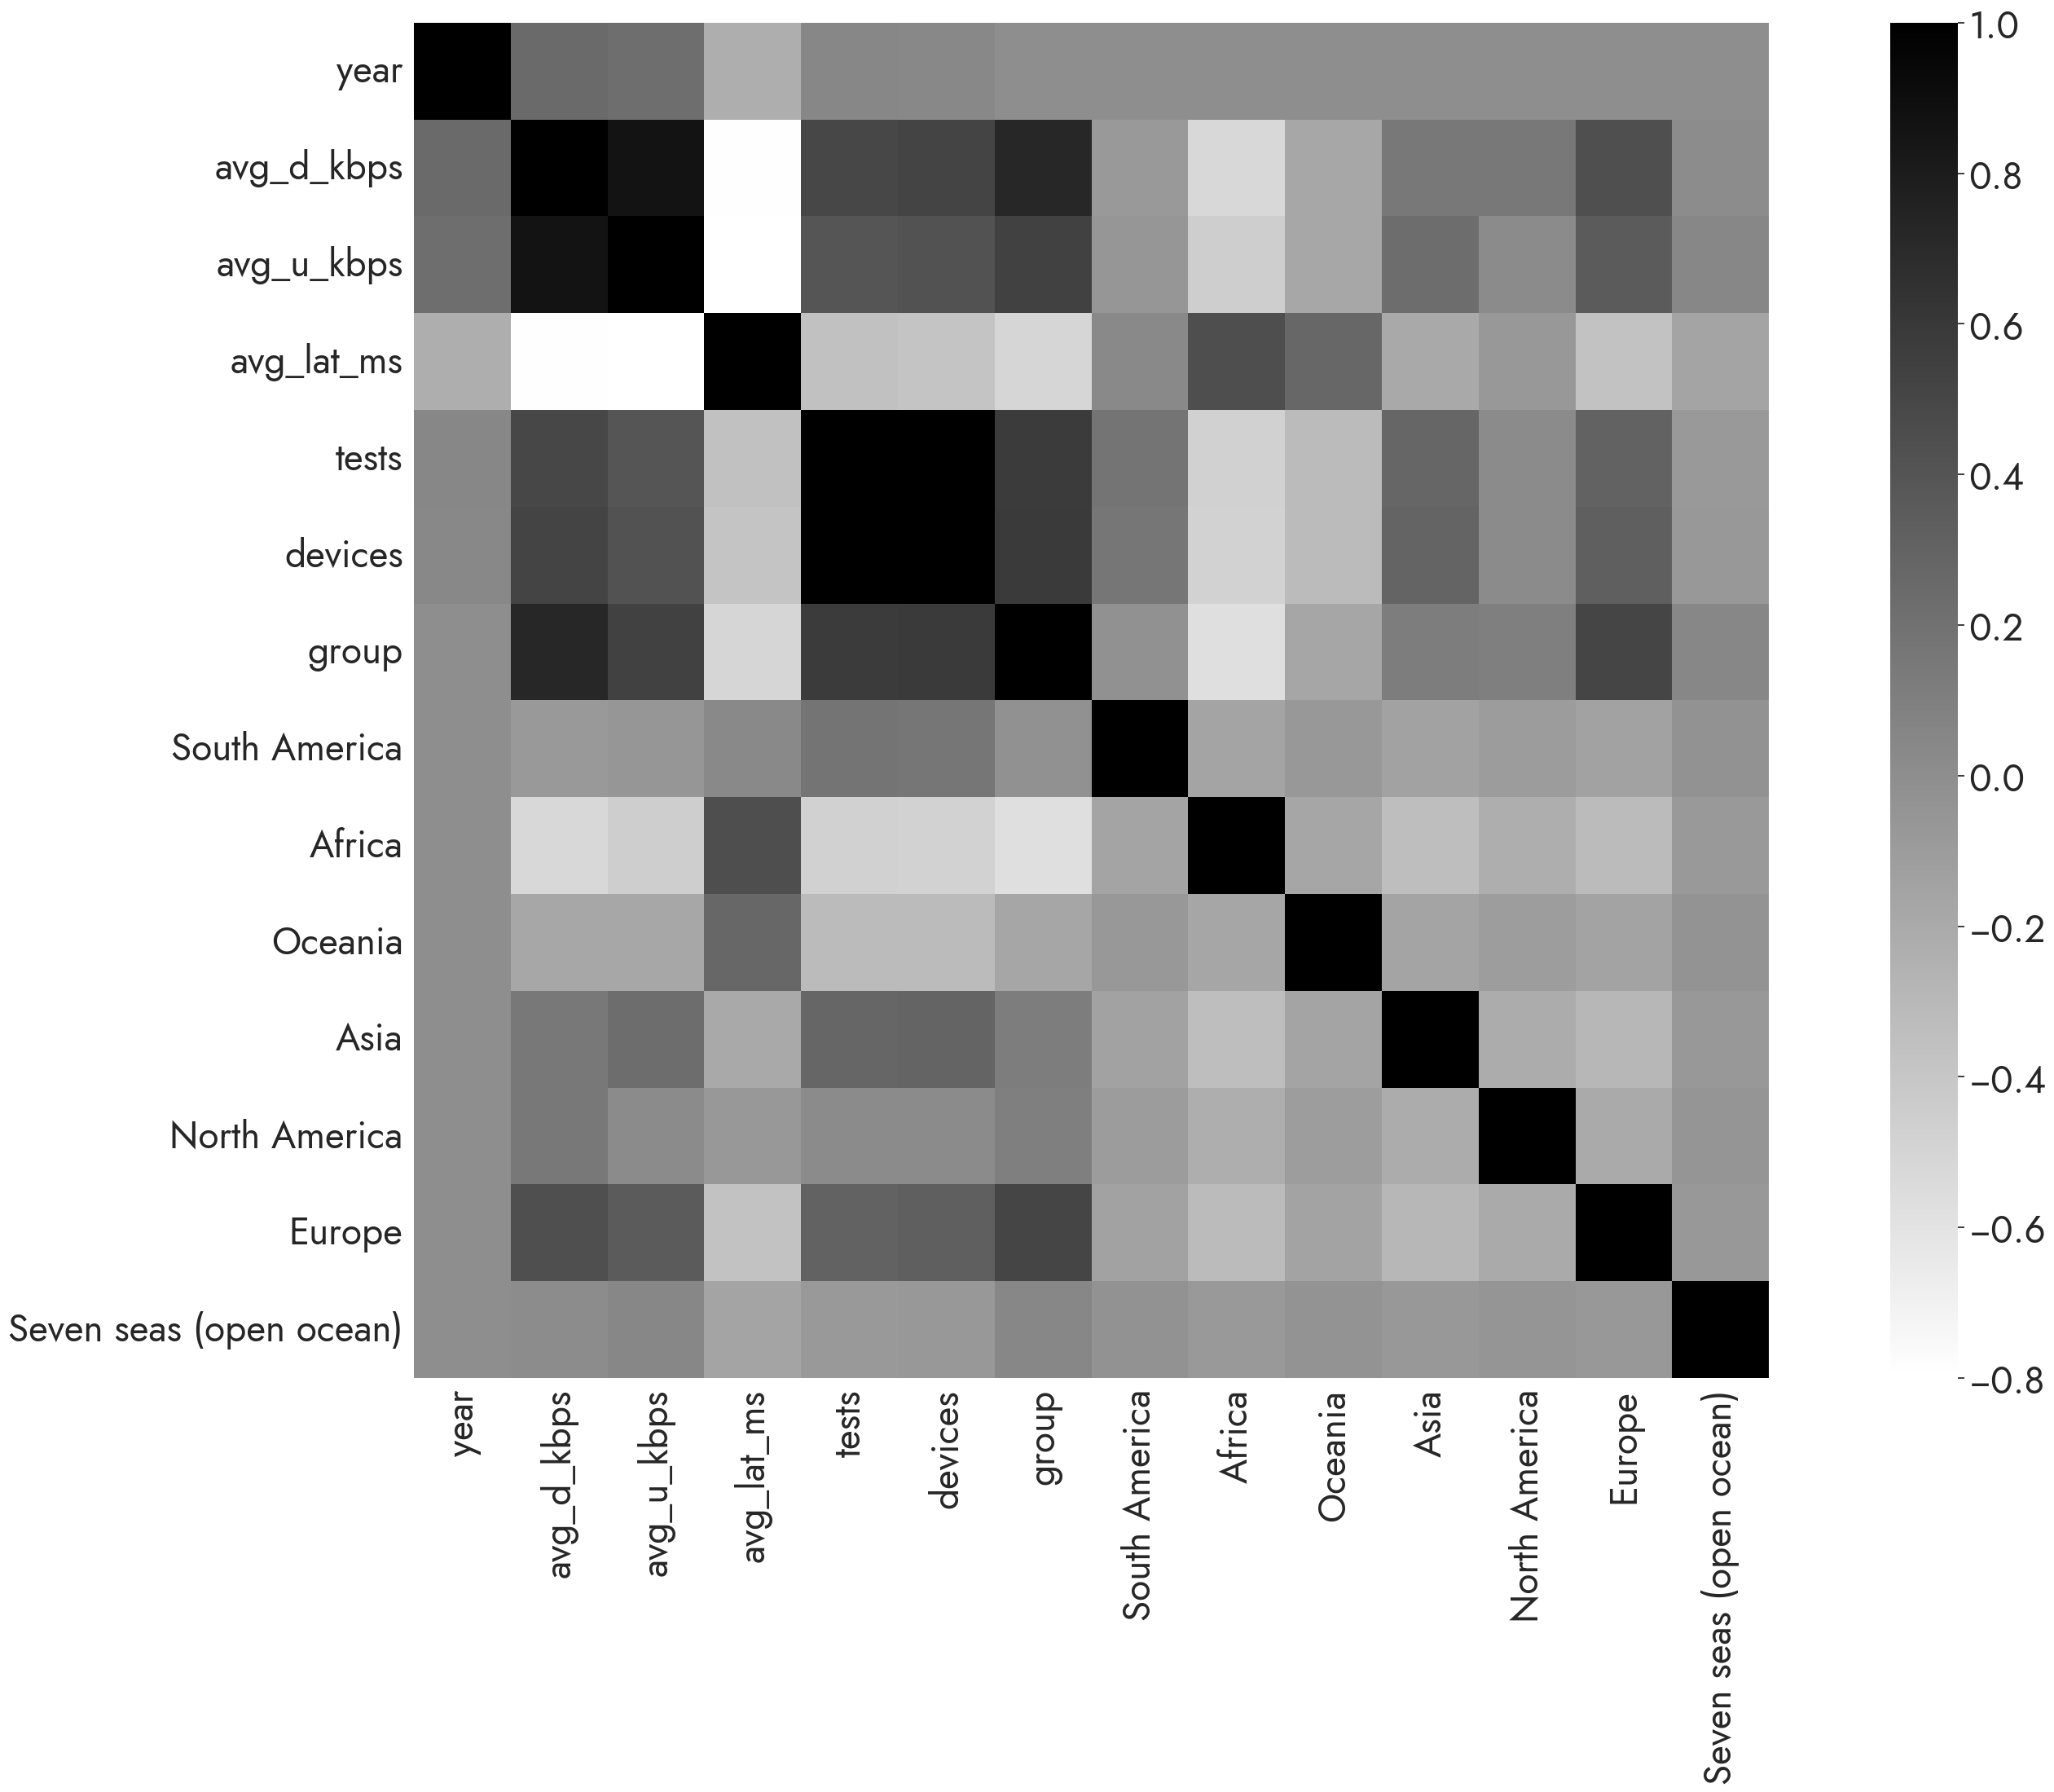

In [11]:
df_plot_corr = sns.heatmap(df_corr, cmap='gray_r', square=True);

In [12]:
df_plot_corr.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_corr.png', transparent=True)

Разделим датасет на обучающий набор - 80%, и на тестовый - 20%:

In [13]:
train_df = df.sample(frac=0.8, random_state=SEED)
test_df = df.drop(train_df.index)

print(f'{len(train_df)} training examples')
print(f'{len(test_df)} training examples')

608 training examples
152 training examples


Выделим целевой признак и преобразуем его в бинарную dummy-переменную.

In [14]:
train_features = train_df.copy()
train_target = train_features.pop('group')

In [15]:
test_features = test_df.copy()
test_target = test_features.pop('group')

## Linear Machine Learning
Построим несколько моделей, основанных на линейных методах машинного обучения.

In [16]:
def fit_and_plot(model, arg: str, epochs: range | list = range(1, 101), patience: int = 5, **kwargs):
    histories = []

    for epoch in epochs:
        print(f'Epoch {epoch}/{len(epochs)}')

        epoch_model = model(**{arg: epoch}, **kwargs)
        epoch_model.fit(train_features, train_target)

        score = epoch_model.score(train_features, train_target)
        test_score = epoch_model.score(test_features, test_target)

        histories.append({'model': epoch_model, 'score': score, 'test_score': test_score})

        print(f'score: {round(score, 4)} - test_score: {round(test_score, 4)}')

        if epoch > 10 and test_score < sum(history['test_score'] for history in histories[-patience:]) / patience:
            print(f'Epoch {epoch}: early stopping')
            break

    history_plot = sns.lineplot(data=pd.DataFrame(histories)[['score', 'test_score']], linewidth=5)

    history_plot.set_xlabel('epoch')
    history_plot.set_ylabel('score')

    return max(histories, key=lambda history: history['test_score']), history_plot

### k-neighbors
Обучим модель с методом классификации k-ближайших соседей.

Epoch 1/100
score: 1.0 - test_score: 0.5789
Epoch 2/100
score: 0.7336 - test_score: 0.4934
Epoch 3/100
score: 0.7188 - test_score: 0.5789
Epoch 4/100
score: 0.7007 - test_score: 0.5
Epoch 5/100
score: 0.6513 - test_score: 0.5
Epoch 6/100
score: 0.6184 - test_score: 0.4803
Epoch 7/100
score: 0.5921 - test_score: 0.4934
Epoch 8/100
score: 0.6086 - test_score: 0.4934
Epoch 9/100
score: 0.6036 - test_score: 0.4539
Epoch 10/100
score: 0.602 - test_score: 0.4671
Epoch 11/100
score: 0.5954 - test_score: 0.4737
Epoch 11: early stopping


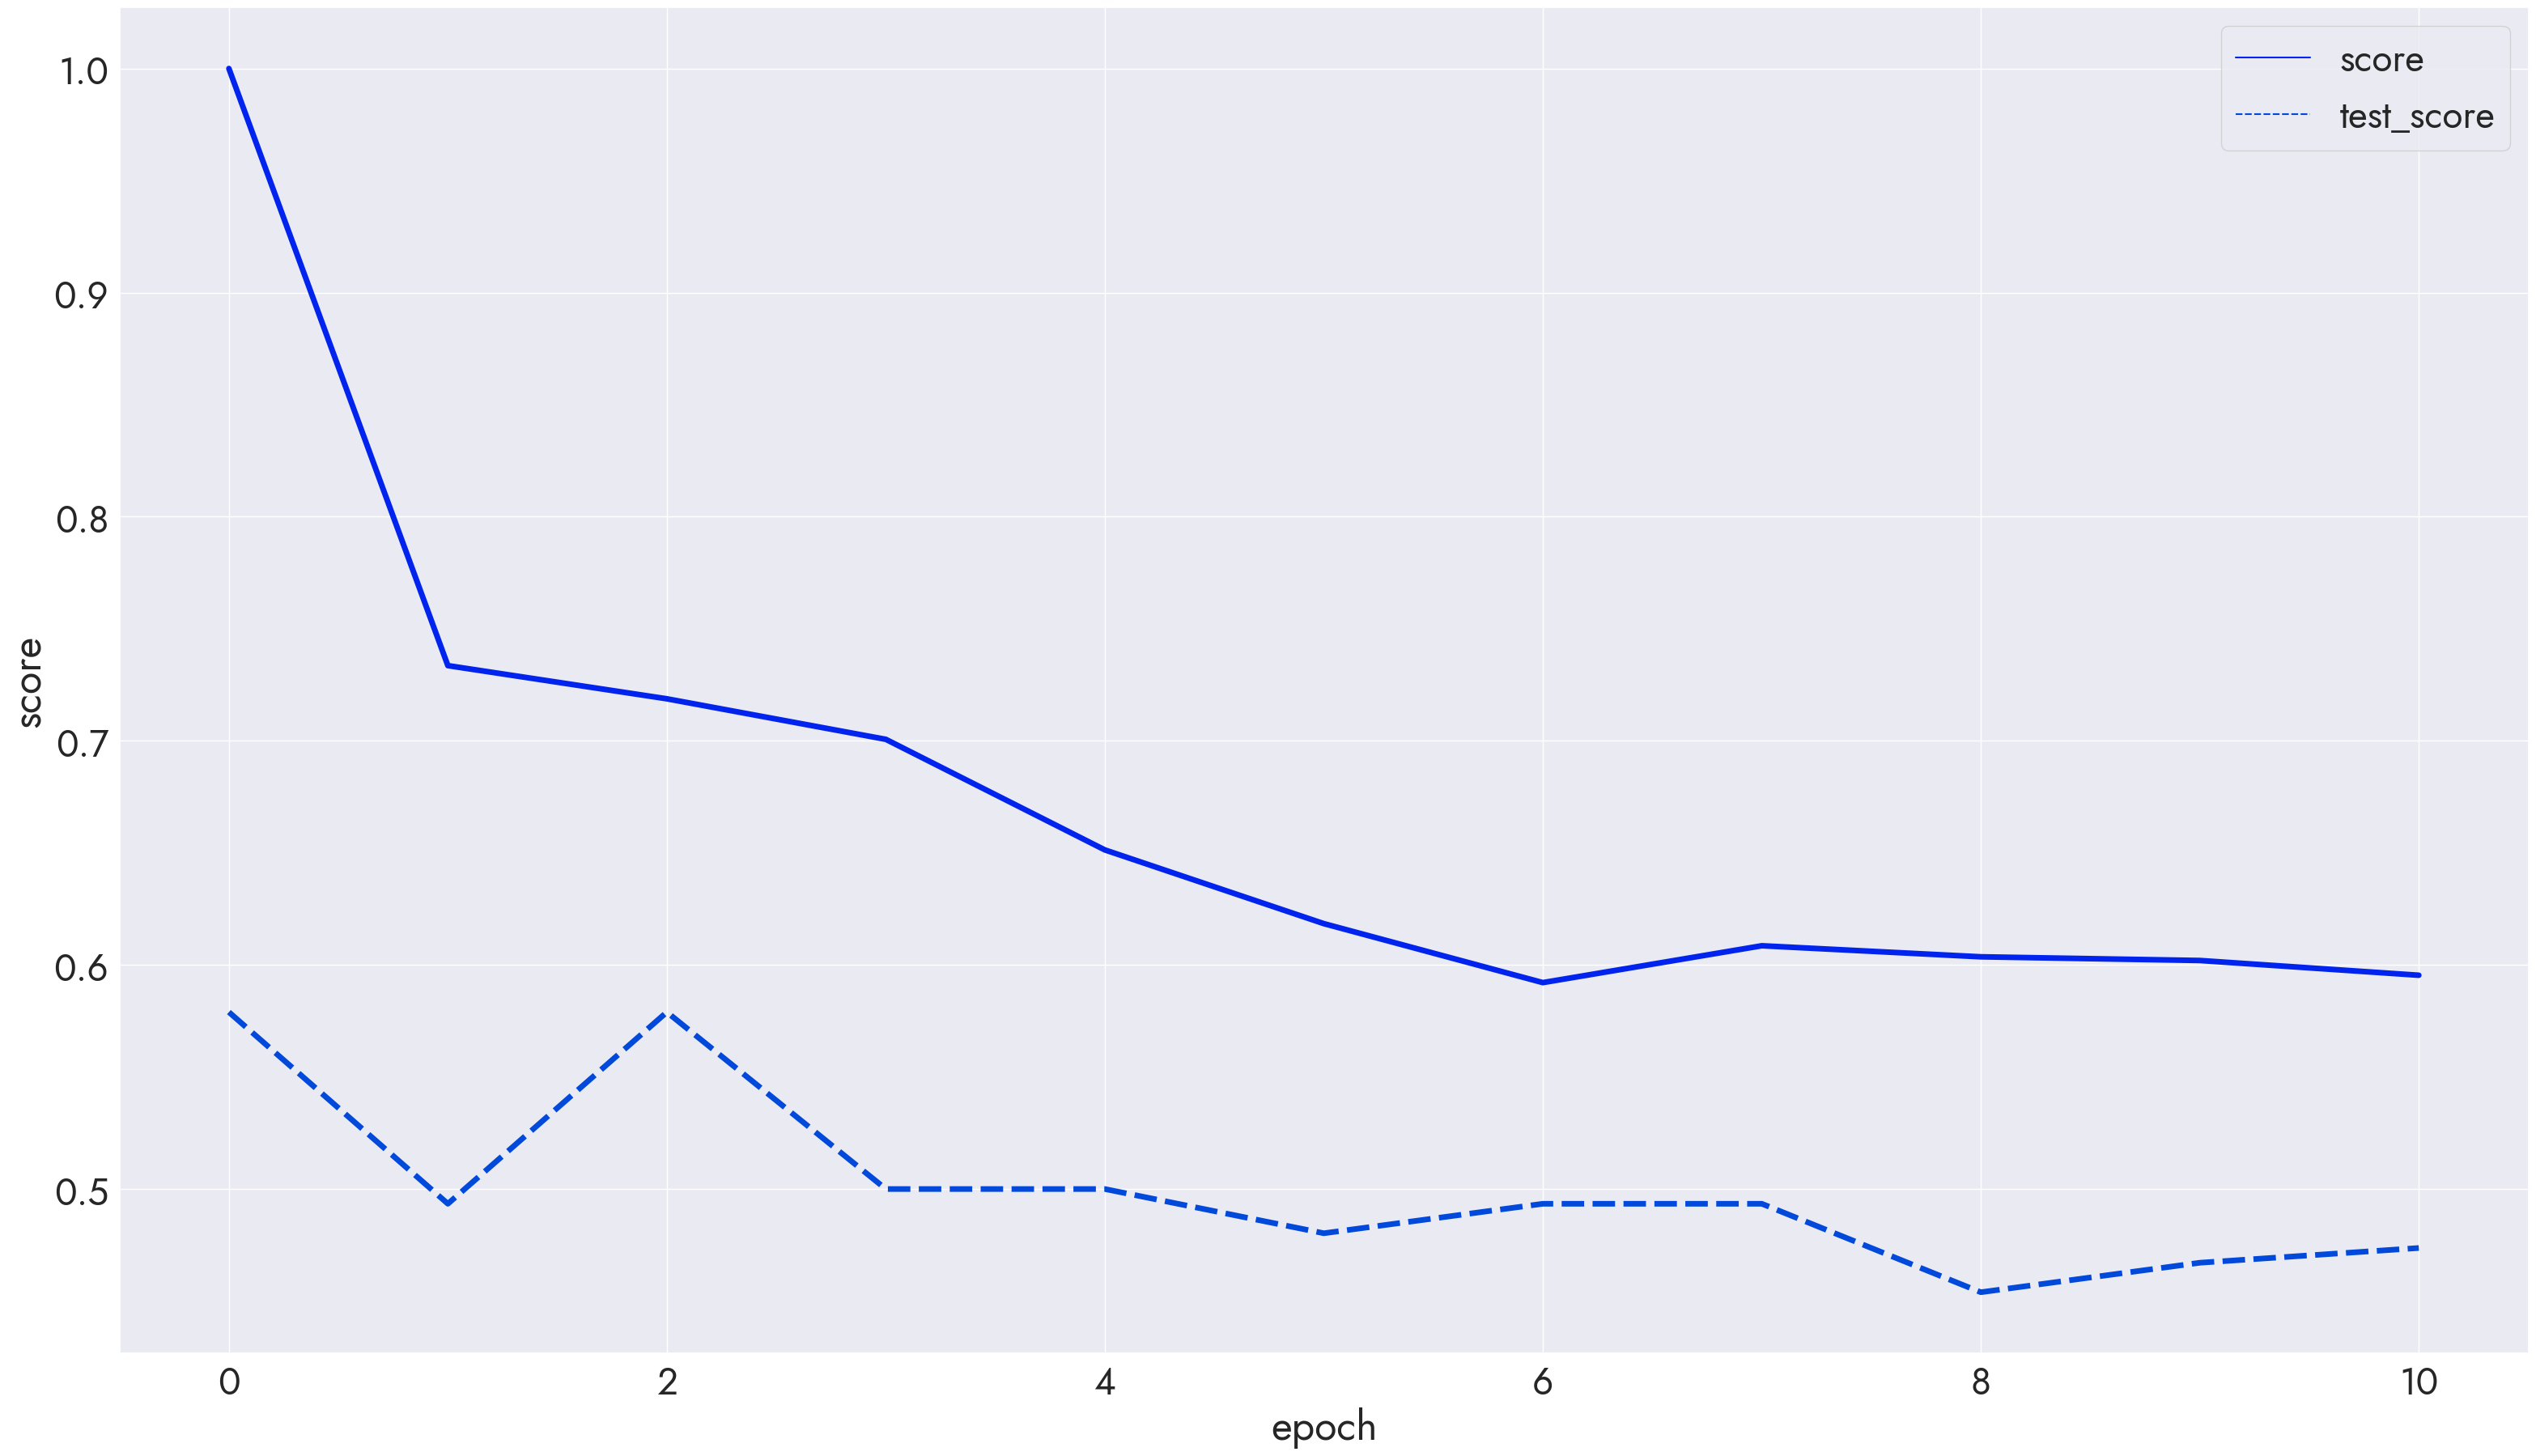

In [17]:
from sklearn.neighbors import KNeighborsClassifier
k_neighbors_model, k_neighbors_plot_history = fit_and_plot(KNeighborsClassifier, arg='n_neighbors')

In [18]:
k_neighbors_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_k_neighbors.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [19]:
print(f"score: {round(k_neighbors_model['score'], 4)}")

score: 1.0


In [20]:
print(f"score: {round(k_neighbors_model['test_score'], 4)}")

score: 0.5789


### decision tree
Обучим модель с методом классификации дерева решений

Epoch 1/100
score: 0.477 - test_score: 0.5
Epoch 2/100
score: 0.5806 - test_score: 0.5461
Epoch 3/100
score: 0.6299 - test_score: 0.6053
Epoch 4/100
score: 0.6941 - test_score: 0.6447
Epoch 5/100
score: 0.7385 - test_score: 0.6776
Epoch 6/100
score: 0.7944 - test_score: 0.6908
Epoch 7/100
score: 0.8438 - test_score: 0.7237
Epoch 8/100
score: 0.8849 - test_score: 0.6974
Epoch 9/100
score: 0.9079 - test_score: 0.7237
Epoch 10/100
score: 0.9359 - test_score: 0.75
Epoch 11/100
score: 0.9605 - test_score: 0.6974
Epoch 11: early stopping


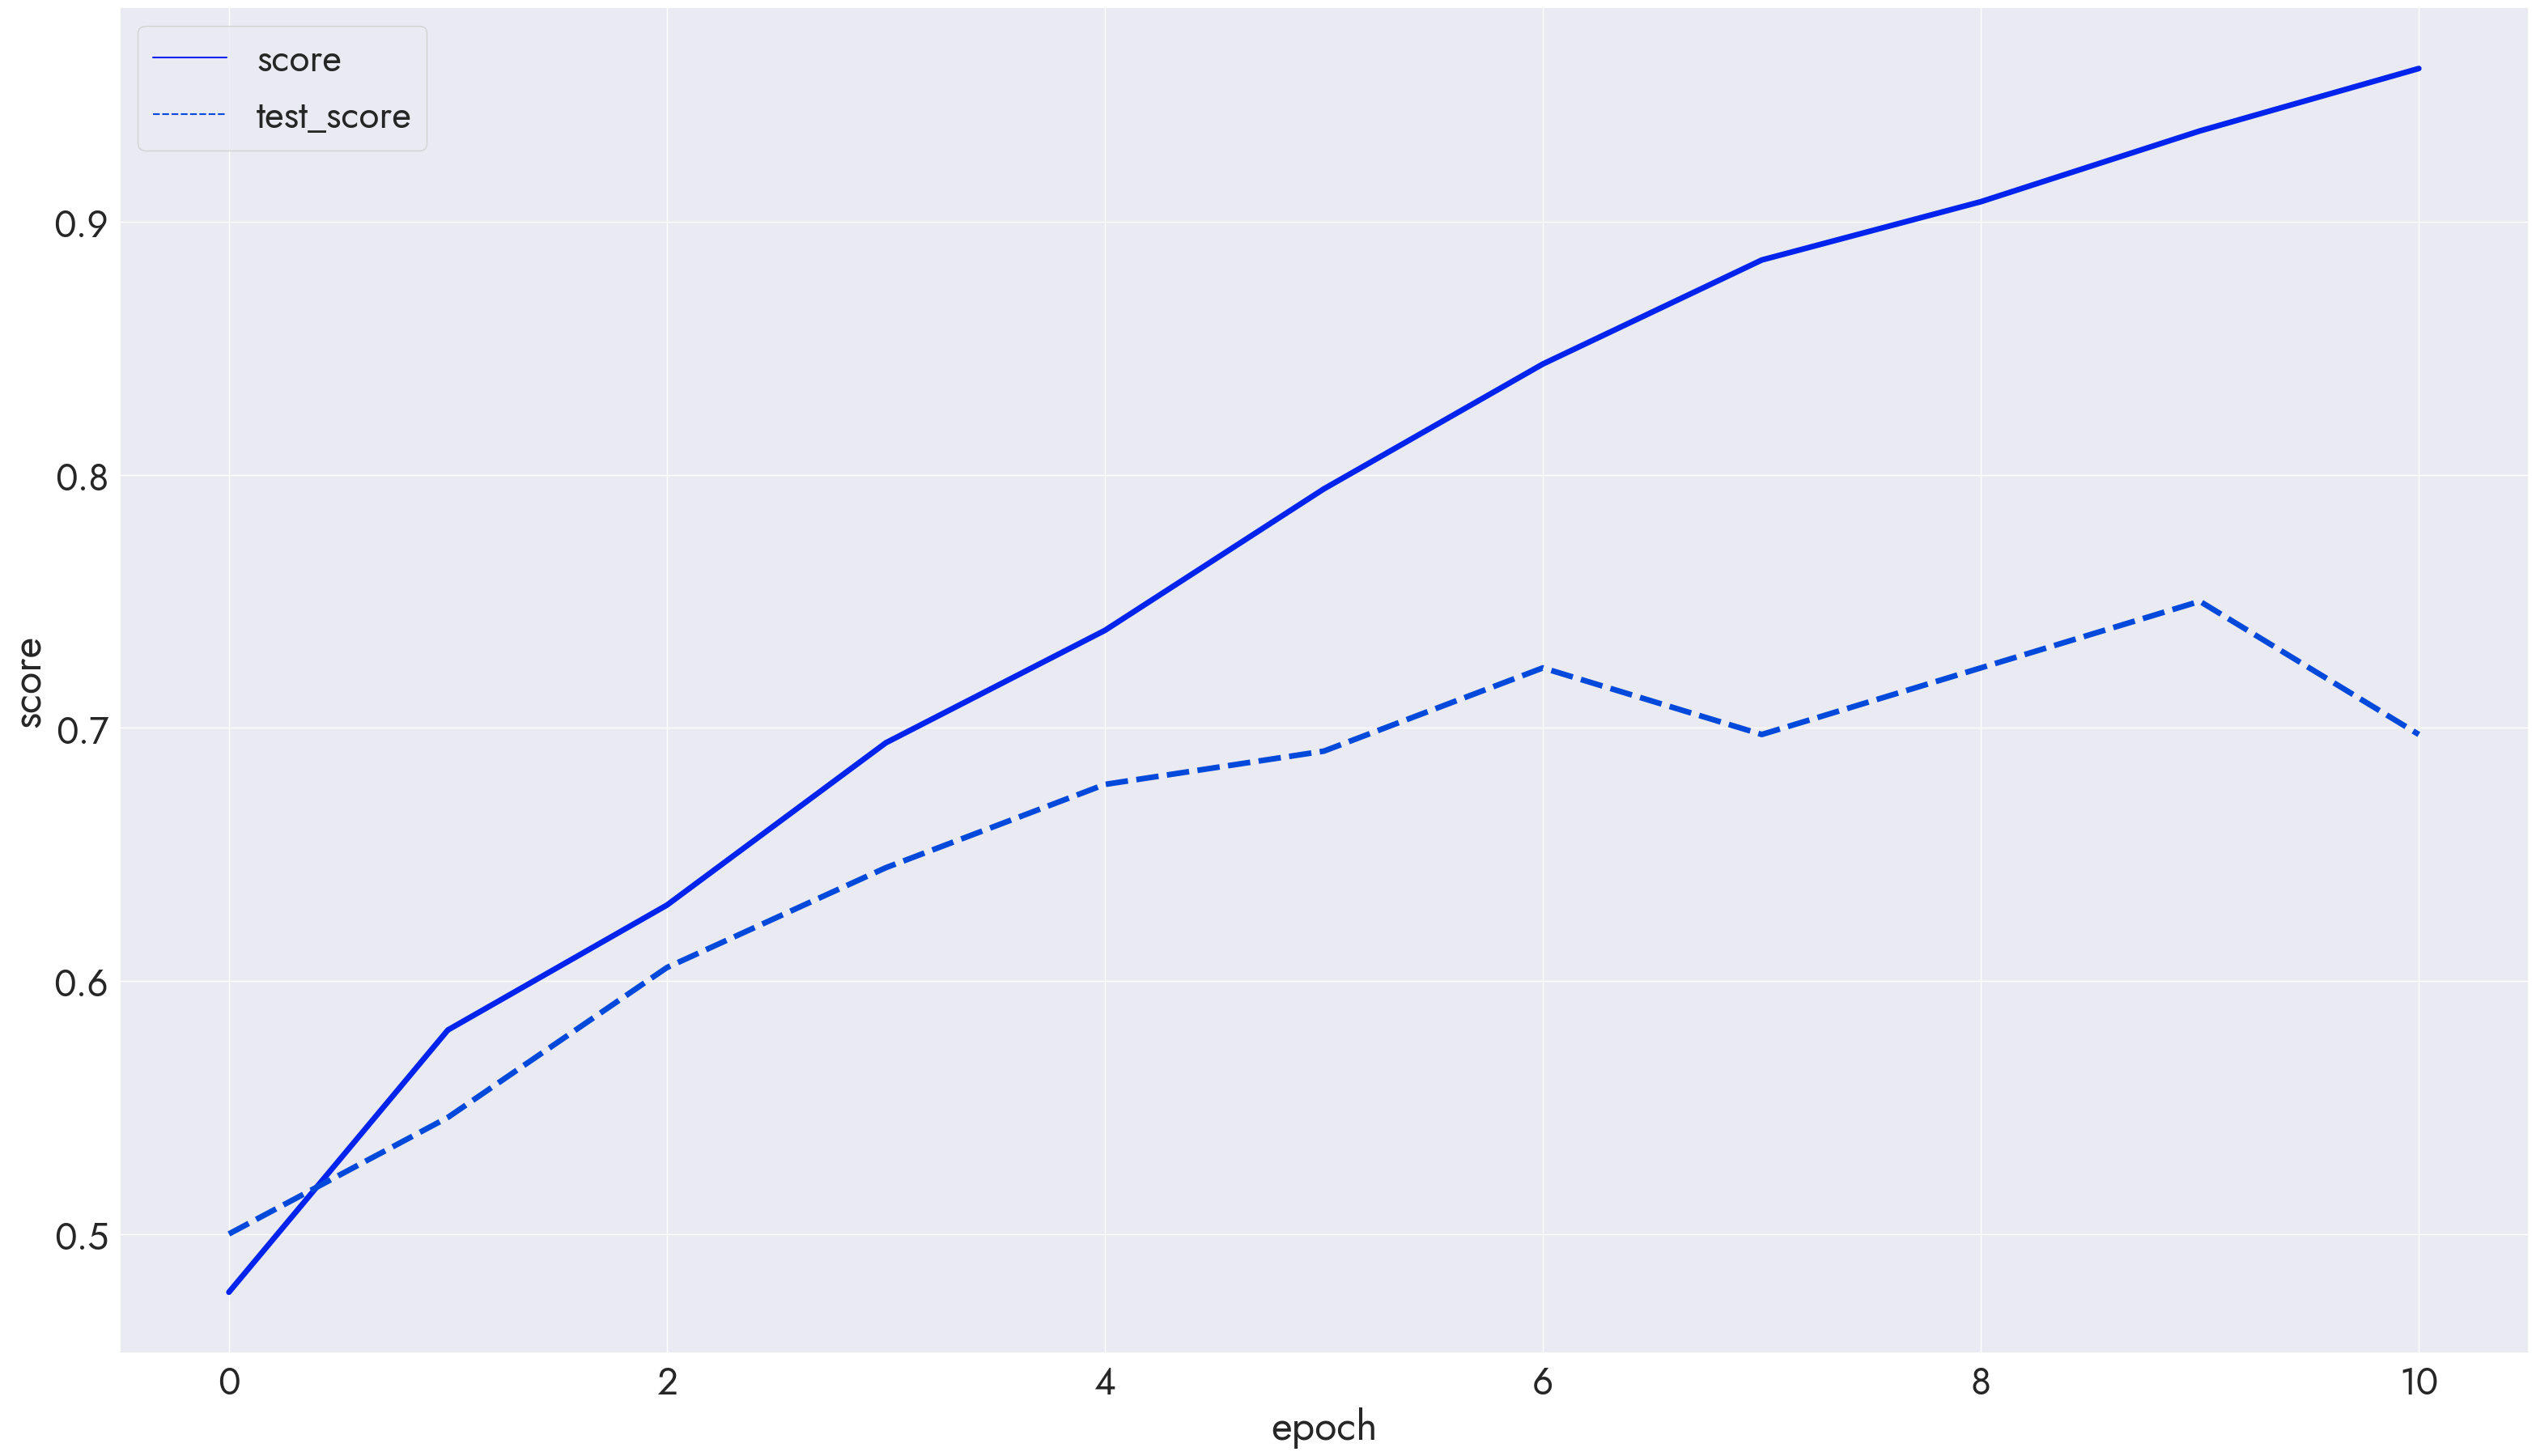

In [21]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_model, decision_tree_plot_history = fit_and_plot(DecisionTreeClassifier, arg='max_depth', random_state=SEED)

In [22]:
decision_tree_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_decision_tree.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [23]:
print(f"score: {round(decision_tree_model['score'], 4)}")

score: 0.9359


In [24]:
print(f"score: {round(decision_tree_model['test_score'], 4)}")

score: 0.75


### svc
Обучим модель с методом классификации дерева решений

Epoch 1/100
score: 0.3766 - test_score: 0.3947
Epoch 2/100
score: 0.4095 - test_score: 0.4079
Epoch 3/100
score: 0.4112 - test_score: 0.4079
Epoch 4/100
score: 0.4178 - test_score: 0.4145
Epoch 5/100
score: 0.4227 - test_score: 0.4211
Epoch 6/100
score: 0.4326 - test_score: 0.4145
Epoch 7/100
score: 0.4375 - test_score: 0.4145
Epoch 8/100
score: 0.4375 - test_score: 0.4211
Epoch 9/100
score: 0.4391 - test_score: 0.4276
Epoch 10/100
score: 0.4391 - test_score: 0.4211
Epoch 11/100
score: 0.4424 - test_score: 0.4211
Epoch 12/100
score: 0.4441 - test_score: 0.4211
Epoch 12: early stopping


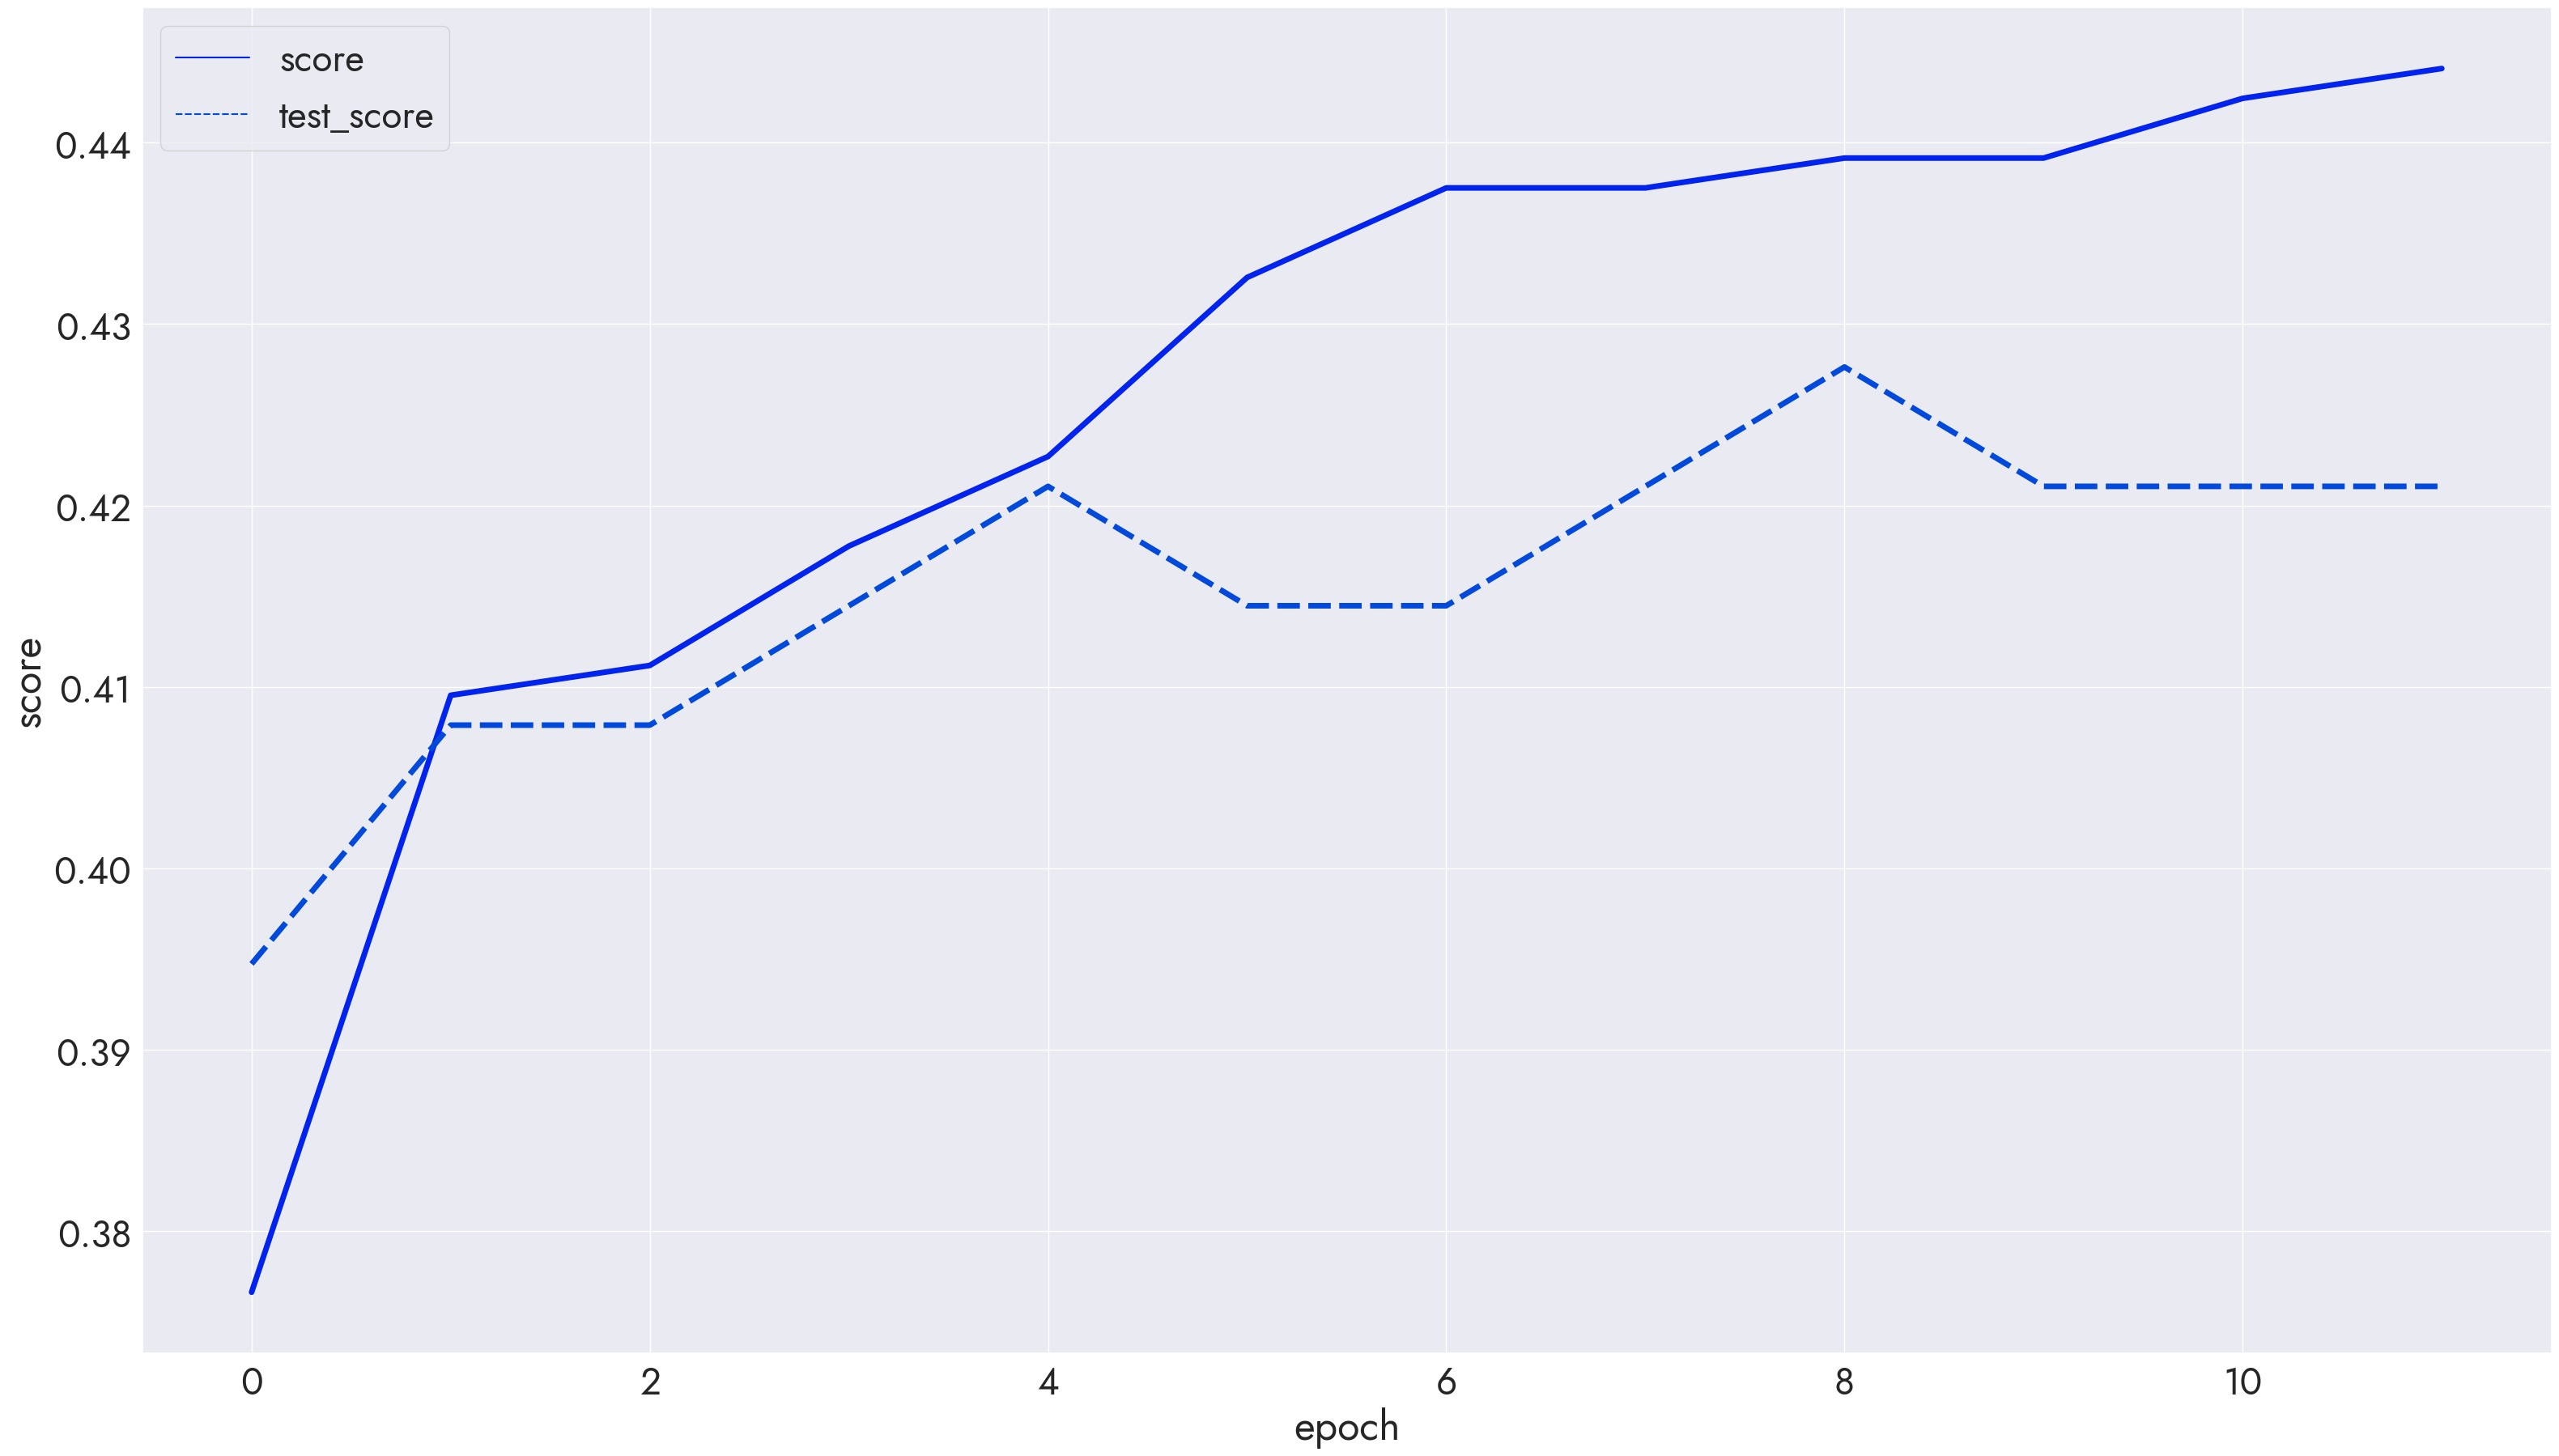

In [25]:
from sklearn.svm import SVC
svc_model, svc_plot_history = fit_and_plot(SVC, arg='C', random_state=SEED)

In [26]:
svc_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_svc.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [27]:
print(f"score: {round(svc_model['score'], 4)}")

score: 0.4391


In [28]:
print(f"score: {round(svc_model['test_score'], 4)}")

score: 0.4276


### finally
Проанализируем модель, имеющую наибольшую точность предсказаний на тестовой выборке.

In [29]:
linear_model = decision_tree_model['model']

С помощью данной модели предскажем результирующий показатель тестовой выборки:

In [30]:
test_predict = pd.Series(linear_model.predict(test_features), index=test_df.index)

Рассмотрим распределение предсказаний модели по группам:

In [31]:
from sklearn.metrics import confusion_matrix

linear_dist = pd.DataFrame(confusion_matrix(test_target, test_predict),
                           index=groups, columns=groups)
linear_dist

,Low income,Lower-middle income,Upper-middle income,High income
Low income,37,3,3,0
Lower-middle income,4,22,8,0
Upper-middle income,4,9,23,3
High income,0,2,2,32


Выведем данную таблицу на тепловую карту:

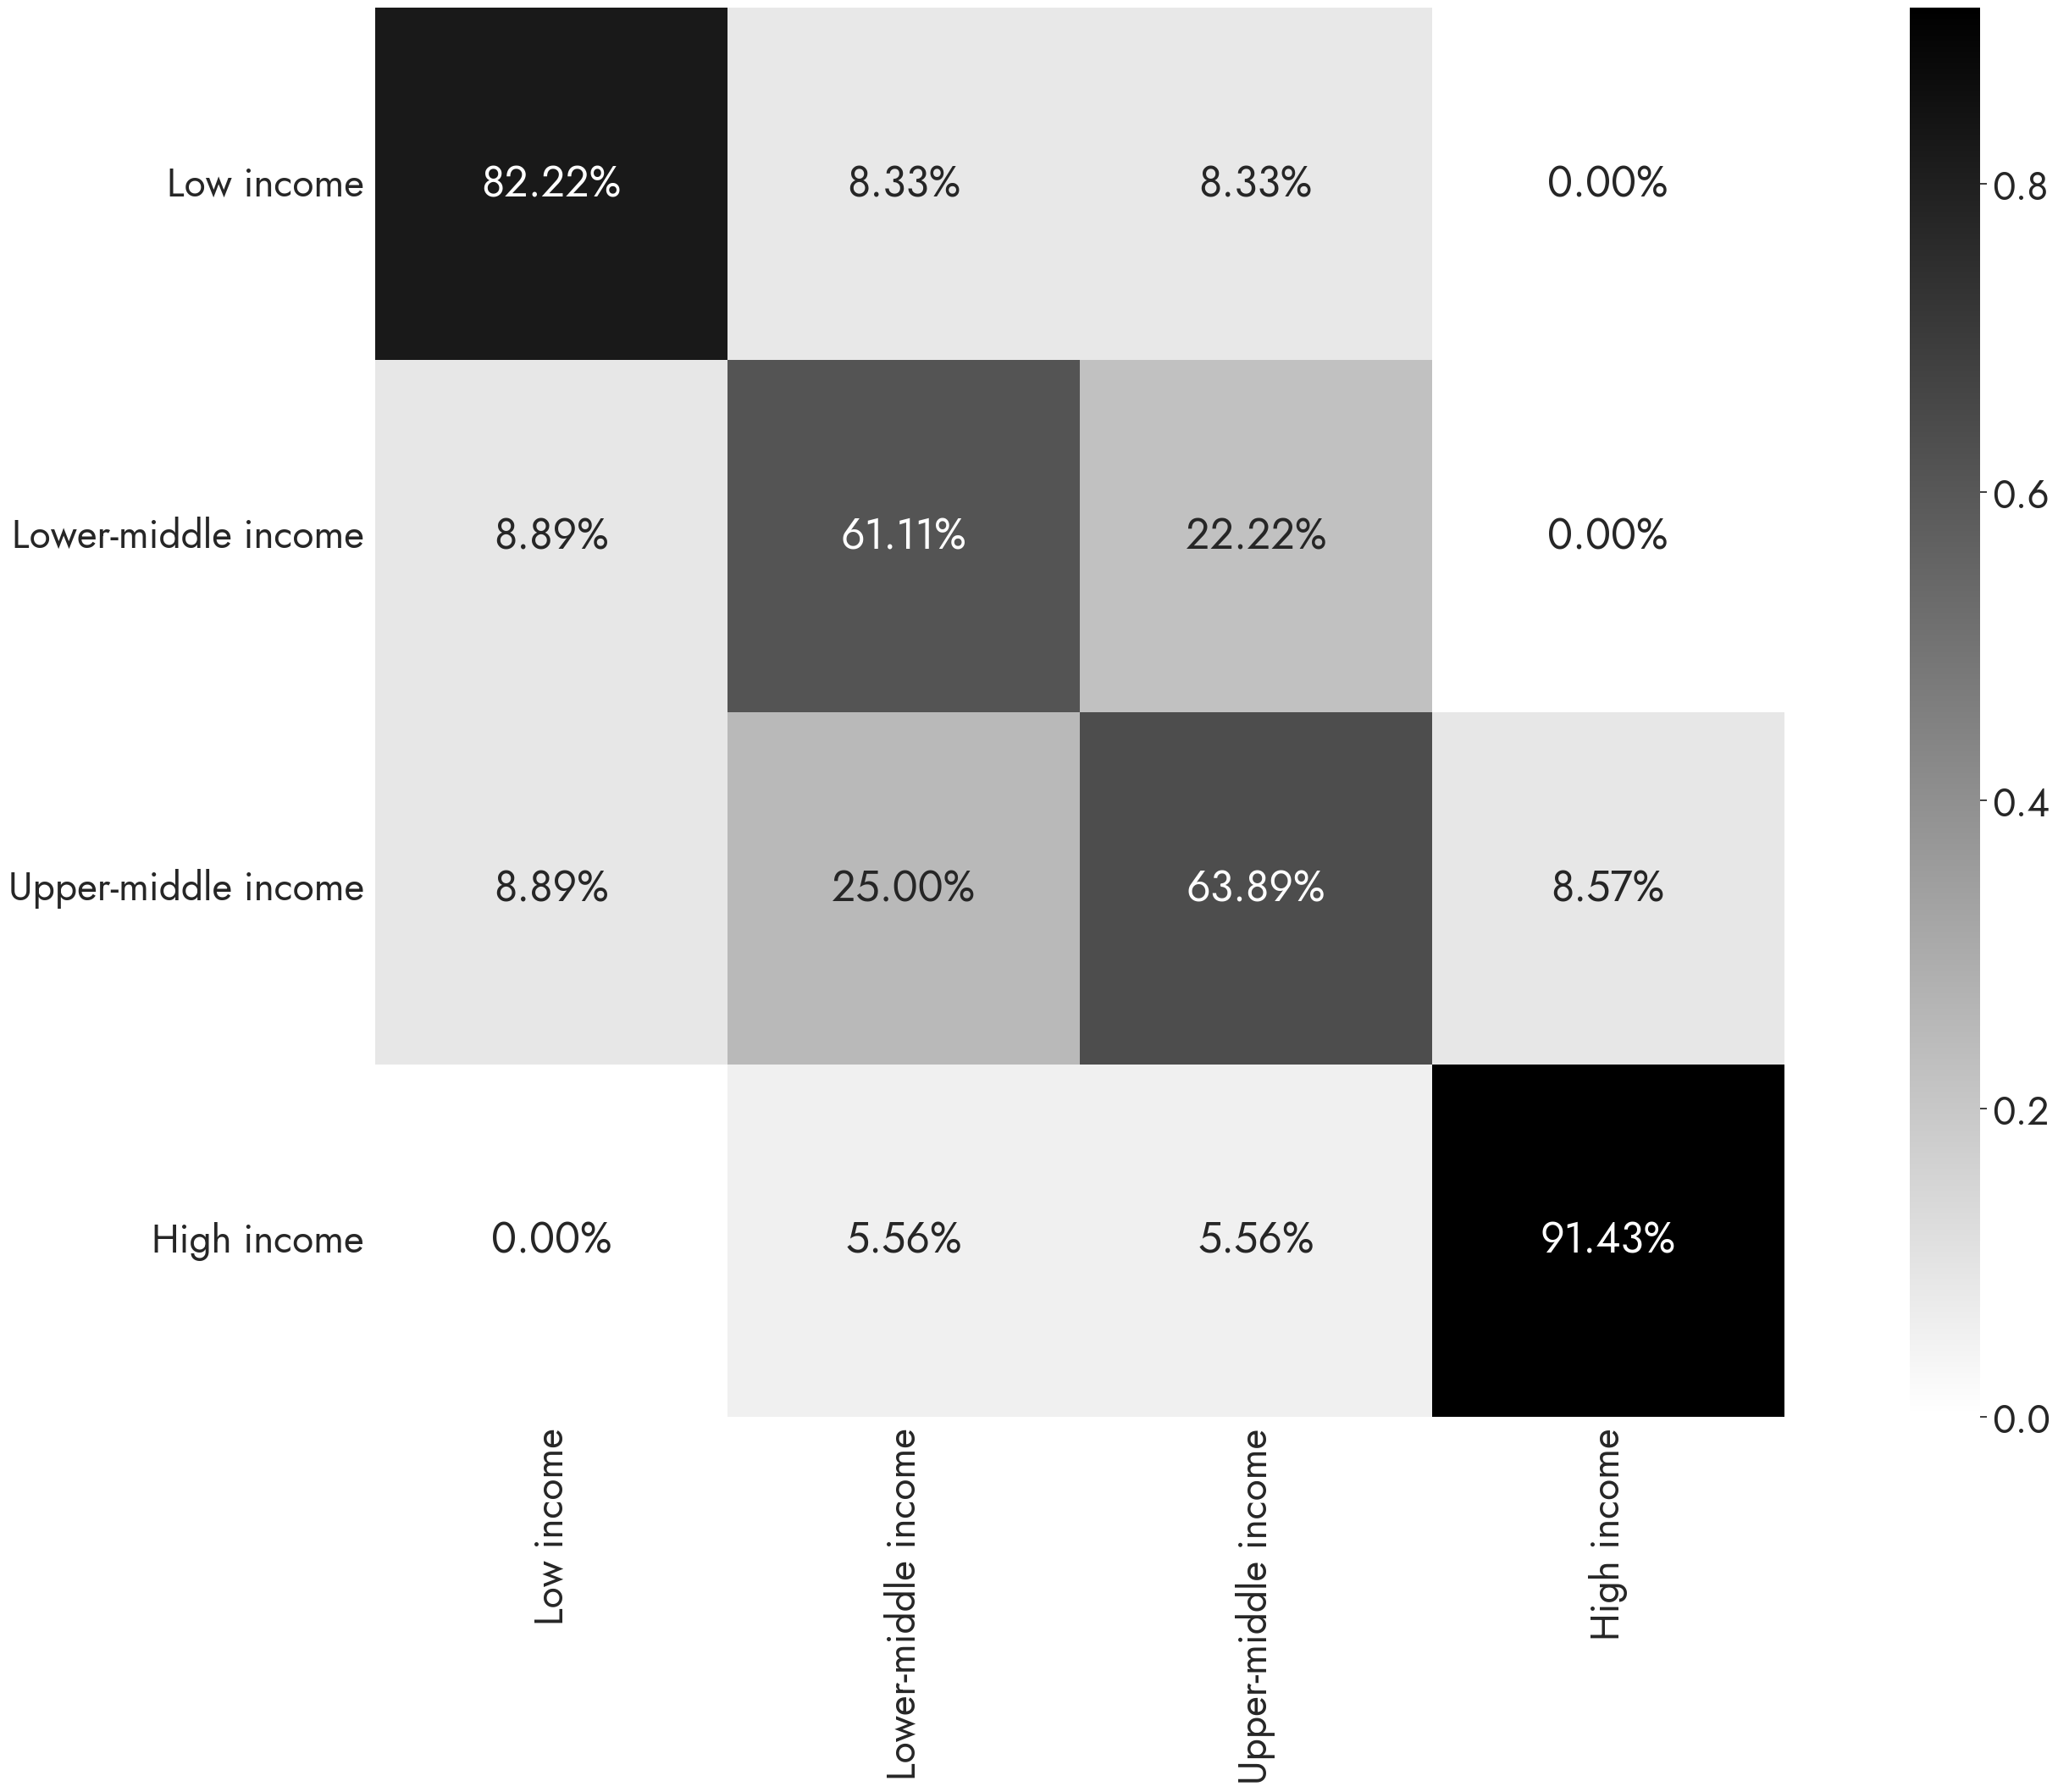

In [32]:
linear_plot_dist = sns.heatmap(linear_dist / linear_dist.sum(), cmap='gray_r', annot=True, fmt='.2%', square=True)

linear_plot_dist.set_xlabel(None);

In [33]:
linear_plot_dist.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_dist_linear.png', transparent=True)

Как видно по сводной таблице и по графику, модель в большинстве случаев неверно определяет группу.
Визуализируем распределение ошибок в модели:

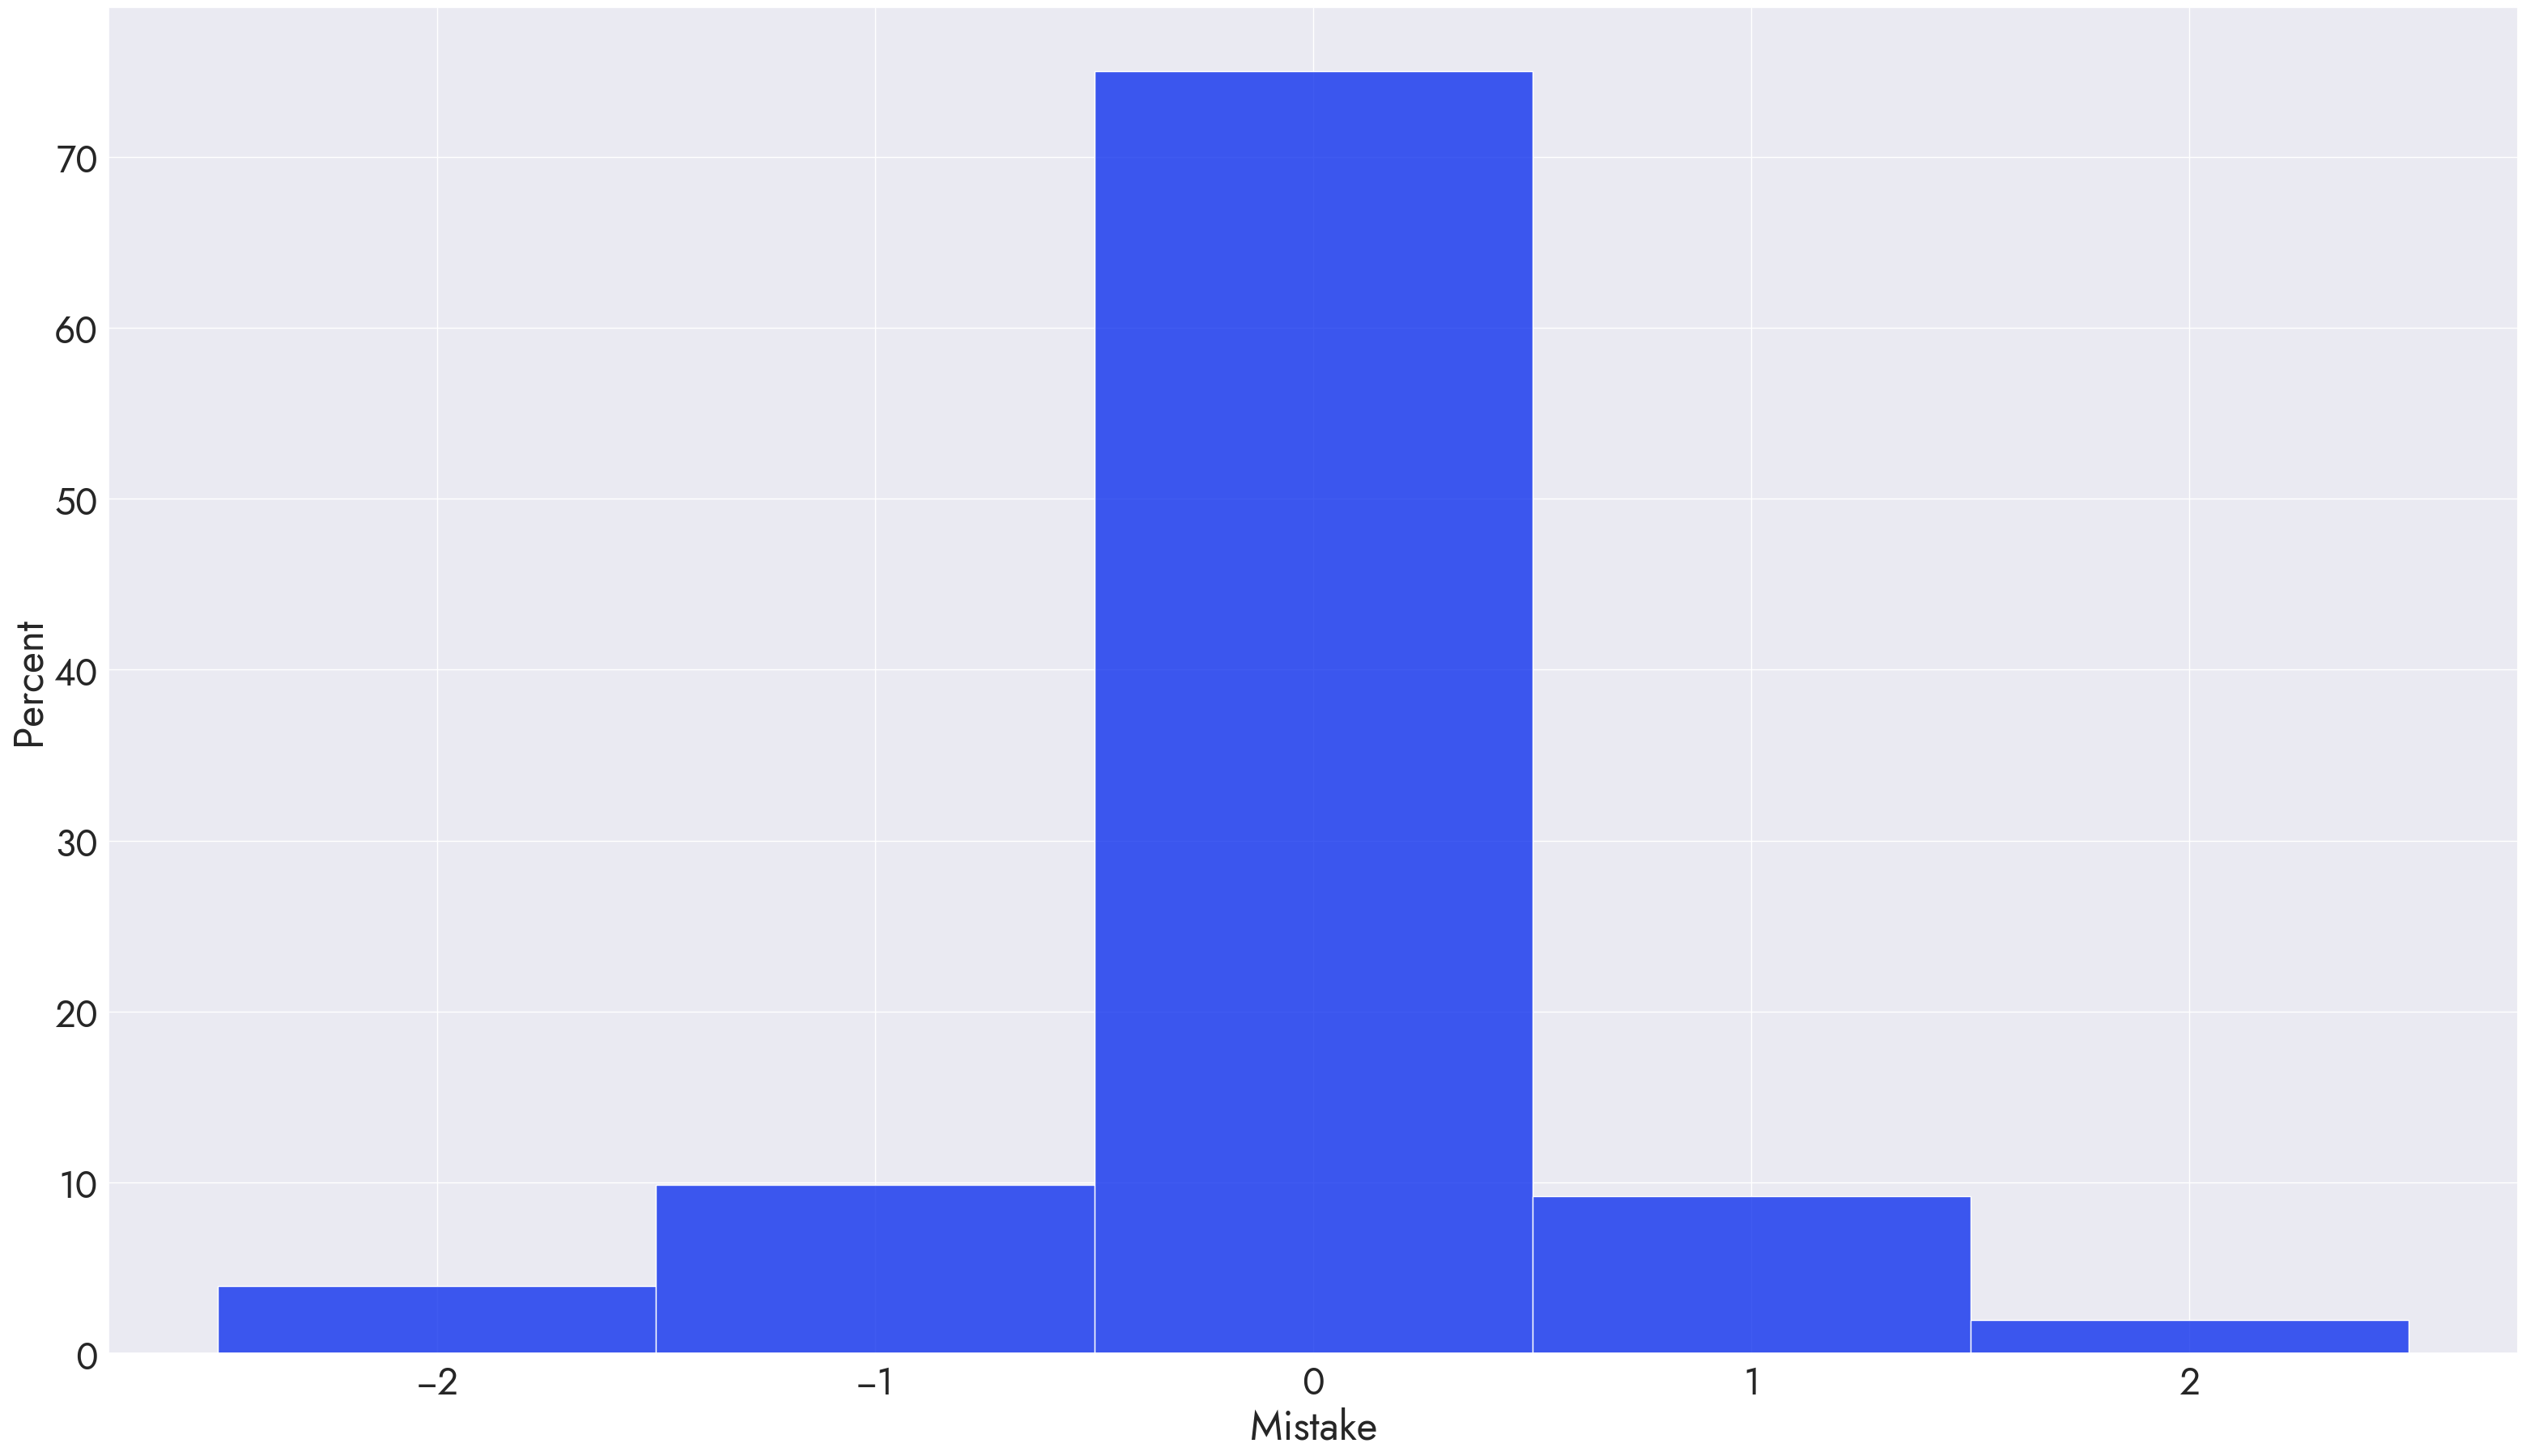

In [34]:
linear_plot_mistakes = sns.histplot(data=test_predict - test_target,
                                    stat='percent', legend=False, discrete=True)

linear_plot_mistakes.set_xlabel('Mistake');

In [35]:
linear_plot_mistakes.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_mistakes_linear.png', transparent=True)

Большинство наблюдений было предсказано правильно - при этом распределение ошибок имеет нормальный вид, в среднем модель ошибается в рамках соседних групп.
Однако все модели имеют тенденцию к переобучению - их точность на обучающем наборе значительно выше, чем на тестовом.

## Setting
В дальнейшем предполагается построение нескольких моделей, различающихся по крупности.
Напишем общую функцию их настройки и обучения:
* optimizer - формула, по которой происходит оптимизация модели
* loss - формула, по которой рассчитываются ошибки предсказаний модели
* batch_size - размер совокупности наблюдений, по которым модель обучается за раз
* callbacks - дополнительные параметры, в данном случае отвечающие за остановку обучения в случае минимальных изменений от эпохи, а также за запись процесса обучения

In [16]:
def compile_and_fit(model: tf.keras.Sequential, max_epochs: int = 1000, patience: int = 5):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy')
        ],
    )

    model.summary()

    history = model.fit(
        train_features, train_target,
        batch_size=BATCH_SIZE,
        validation_split=0.2,  # 20% of train data will validate model
        epochs=max_epochs,  # number model loops
        verbose=2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, start_from_epoch=10, restore_best_weights=True),
            tf.keras.callbacks.TensorBoard(f'{LOGS_PATH}/{SERIAL_TYPE}_{model.name}'),
        ],
    )

    return history.history

Для обучения моделей целевой показатель должен представлять собой dummy-переменную.
Переведём их:

In [17]:
train_target = tf.keras.utils.to_categorical(train_target, dtype='int8')
test_target = tf.keras.utils.to_categorical(test_target, dtype='int8')

Из ноутбука с визуализацией было выяснено, что признаки имеют выраженное левостороннее распределение.
Создадим слой для их нормализации:

In [18]:
normalize = tf.keras.layers.Normalization()
normalize.adapt(train_features, batch_size=BATCH_SIZE)

2023-05-31 19:32:44.447706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 19:32:44.466911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 19:32:44.466969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 19:32:44.469378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 19:32:44.469480: I tensorflow/compile

Создадим переменную, в которой будут сохраняться логи обучения моделей и их проверка на тестовом наборе:

In [19]:
train_histories = {}
test_results = {}

## Deep neural networks
Построим модели глубоких нейронных сетей (DNN).

### tiny
Обучим модель, состоящую из двух обучающих слоёв.

In [20]:
tiny_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='tiny'
)

In [21]:
train_histories[tiny_model.name] = compile_and_fit(tiny_model)

Model: "tiny"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense (Dense)               (None, 16)                224       
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 319
Trainable params: 292
Non-trainable params: 27
_________________________________________________________________
Epoch 1/1000


2023-05-31 19:32:47.013181: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x56083819db80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-31 19:32:47.013226: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-05-31 19:32:47.019454: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-31 19:32:48.412007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-31 19:32:48.572900: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-31 19:32:48.644055: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 - 3s - loss: 1.6493 - accuracy: 0.1708 - val_loss: 1.6545 - val_accuracy: 0.0984 - 3s/epoch - 214ms/step
Epoch 2/1000
16/16 - 0s - loss: 1.5383 - accuracy: 0.1975 - val_loss: 1.5520 - val_accuracy: 0.1721 - 111ms/epoch - 7ms/step
Epoch 3/1000
16/16 - 0s - loss: 1.4458 - accuracy: 0.2387 - val_loss: 1.4663 - val_accuracy: 0.2295 - 112ms/epoch - 7ms/step
Epoch 4/1000
16/16 - 0s - loss: 1.3680 - accuracy: 0.2881 - val_loss: 1.3938 - val_accuracy: 0.3197 - 118ms/epoch - 7ms/step
Epoch 5/1000
16/16 - 0s - loss: 1.3039 - accuracy: 0.3601 - val_loss: 1.3332 - val_accuracy: 0.3689 - 110ms/epoch - 7ms/step
Epoch 6/1000
16/16 - 0s - loss: 1.2501 - accuracy: 0.4177 - val_loss: 1.2775 - val_accuracy: 0.4098 - 109ms/epoch - 7ms/step
Epoch 7/1000
16/16 - 0s - loss: 1.2054 - accuracy: 0.4877 - val_loss: 1.2340 - val_accuracy: 0.4754 - 117ms/epoch - 7ms/step
Epoch 8/1000
16/16 - 0s - loss: 1.1681 - accuracy: 0.5144 - val_loss: 1.2008 - val_accuracy: 0.4918 - 115ms/epoch - 7ms/step
Epoch 9/1000
1

Визуализируем ход обучения:

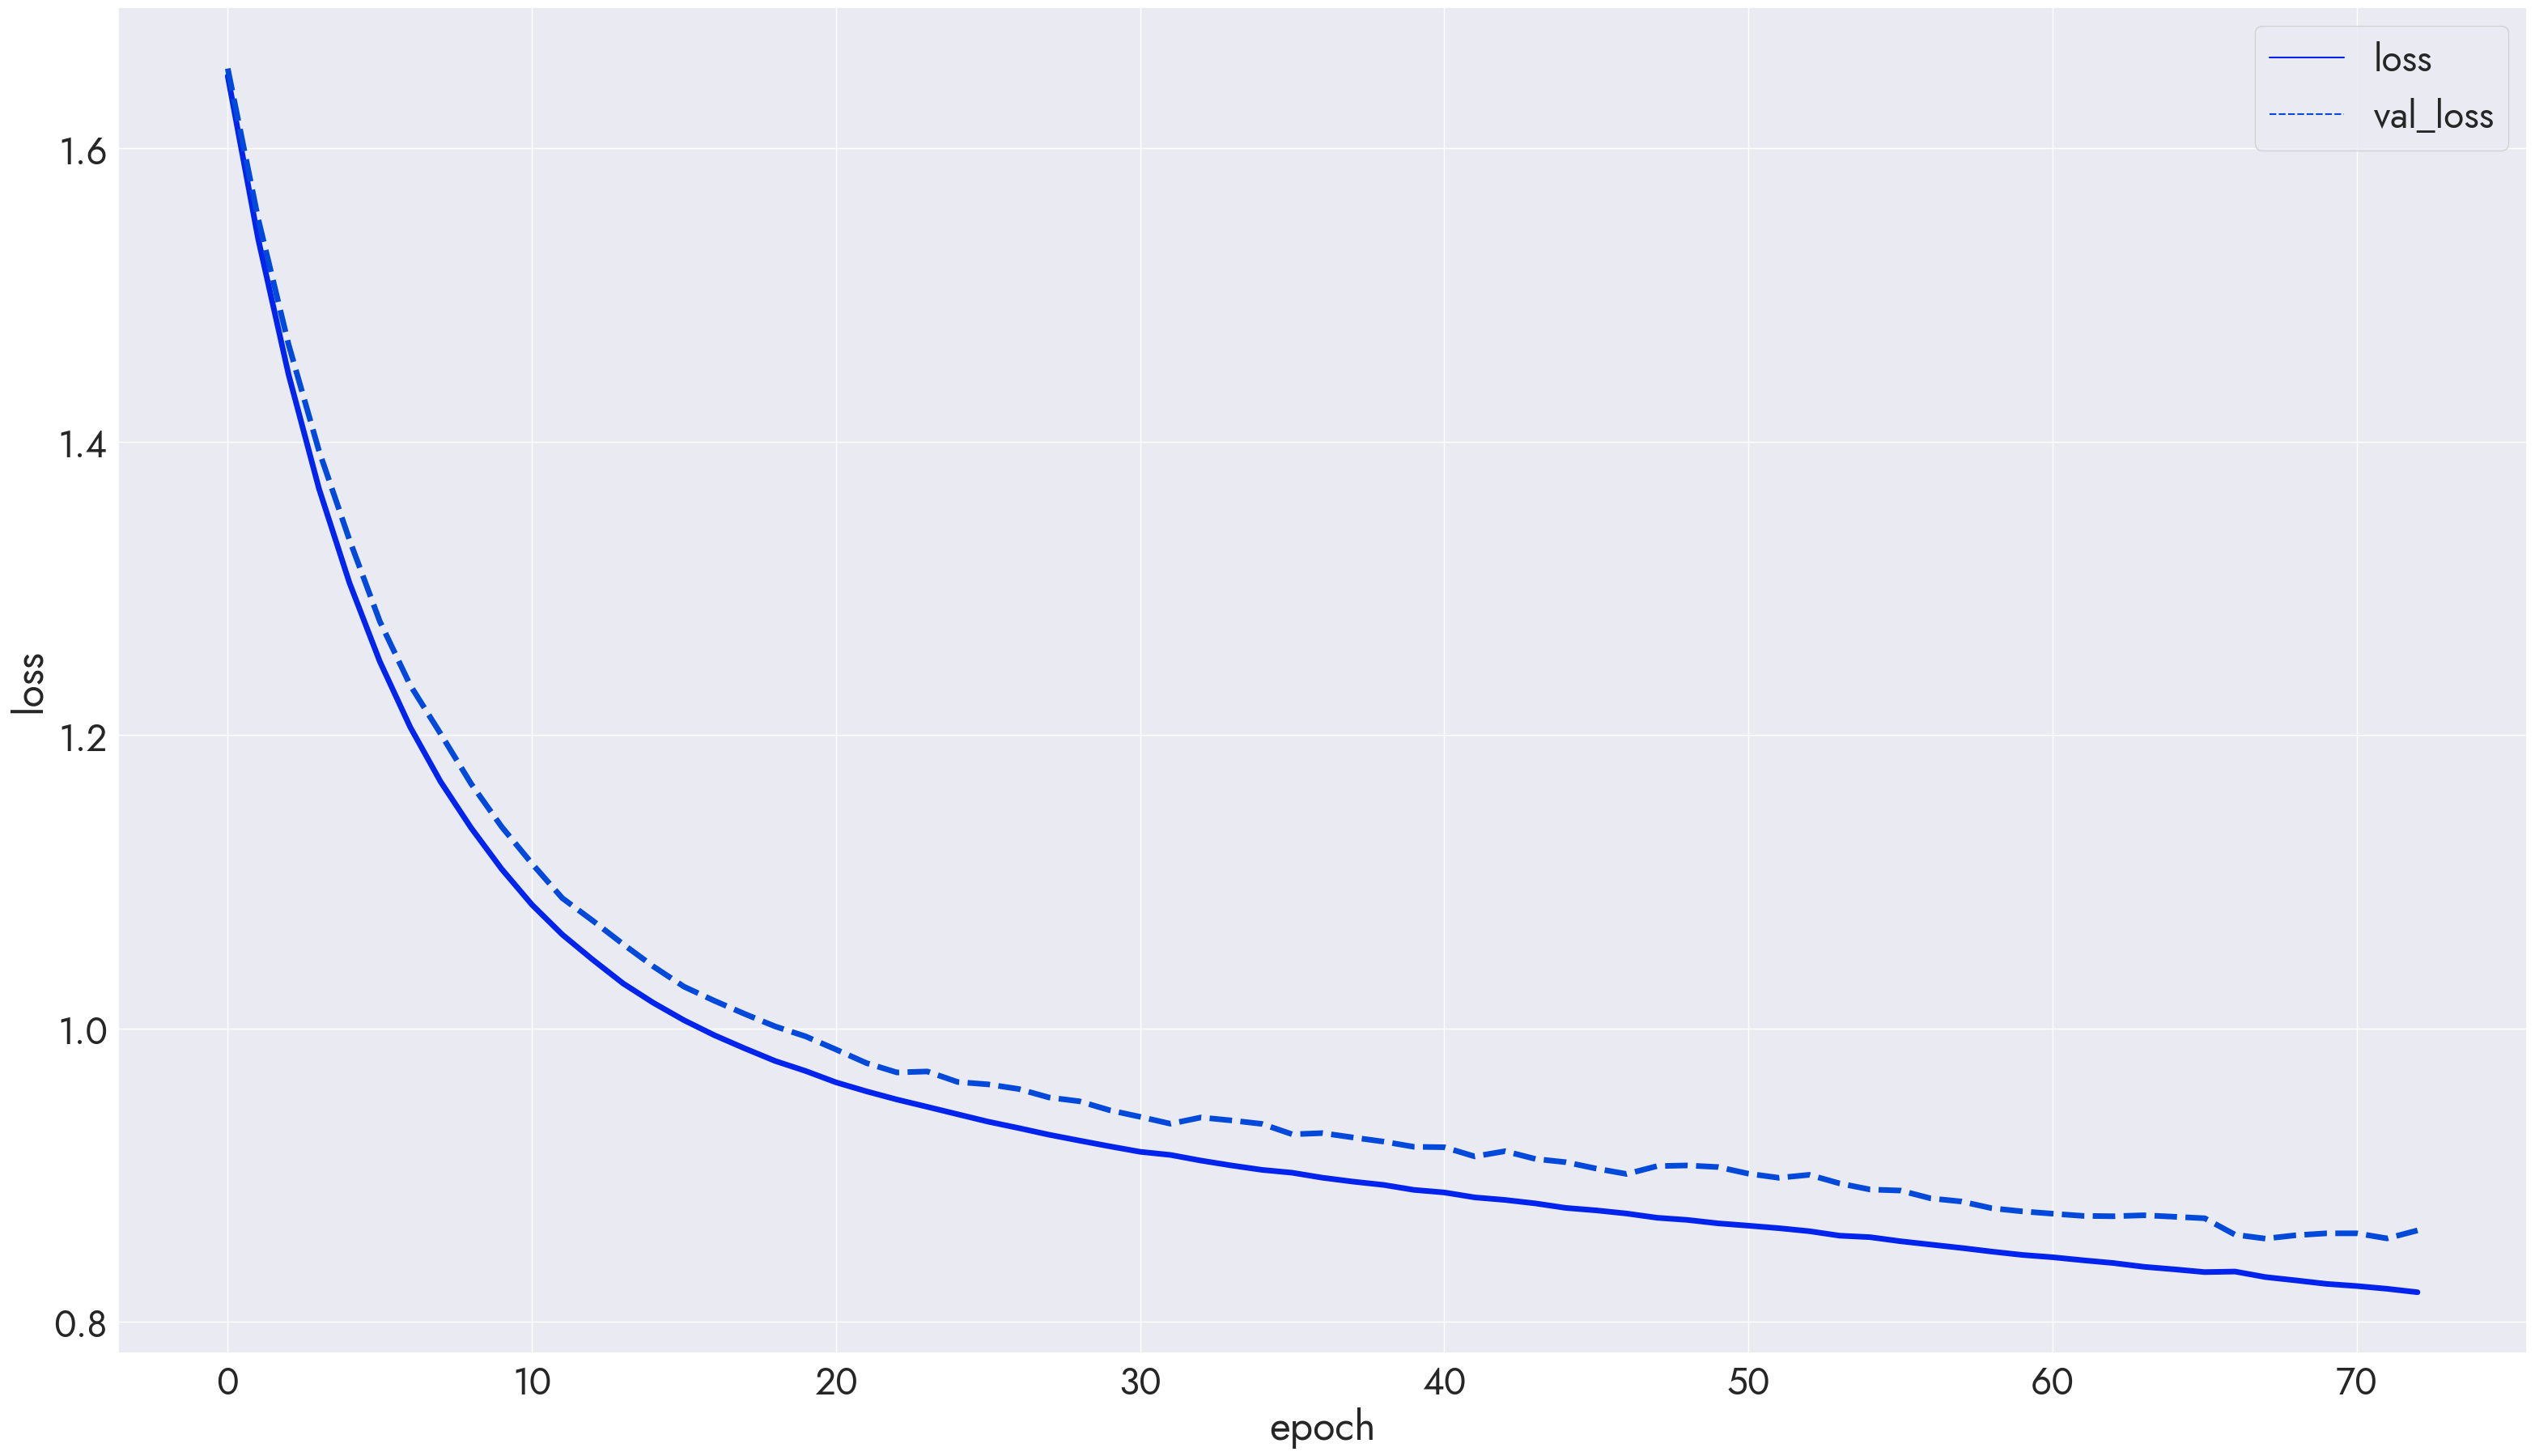

In [22]:
tiny_plot_history = sns.lineplot(data=pd.DataFrame(train_histories[tiny_model.name])[['loss', 'val_loss']], linewidth=5)

tiny_plot_history.set_xlabel('epoch')
tiny_plot_history.set_ylabel('loss');

In [23]:
tiny_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{tiny_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [24]:
tiny_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

19/19 - 0s - loss: 0.8332 - accuracy: 0.6398 - 78ms/epoch - 4ms/step


In [25]:
test_results[tiny_model.name] = tiny_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

5/5 - 0s - loss: 0.8491 - accuracy: 0.6711 - 38ms/epoch - 8ms/step


Сохраним обученную модель:

In [26]:
tiny_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}_{tiny_model.name}')

INFO:tensorflow:Assets written to: model/light/fixed/fixed_tiny/assets


2023-05-31 19:33:01 - tensorflow - INFO - Assets written to: model/light/fixed/fixed_tiny/assets


### small
Обучим модель, состоящую из трёх обучающих слоёв.

In [27]:
small_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(32, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(32, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='small'
)

In [28]:
train_histories[small_model.name] = compile_and_fit(small_model)

Model: "small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 32)                448       
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 4)                 132       
                                                                 
Total params: 1,663
Trainable params: 1,636
Non-trainable params: 27
_________________________________________________________________
Epoch 1/1000
16/16 - 2s - loss: 1.4586 - accuracy: 0.3457 - val_loss: 1.3499 - val_accuracy: 0.4016 - 2s/epoch - 94ms/step
E

Визуализируем ход обучения:

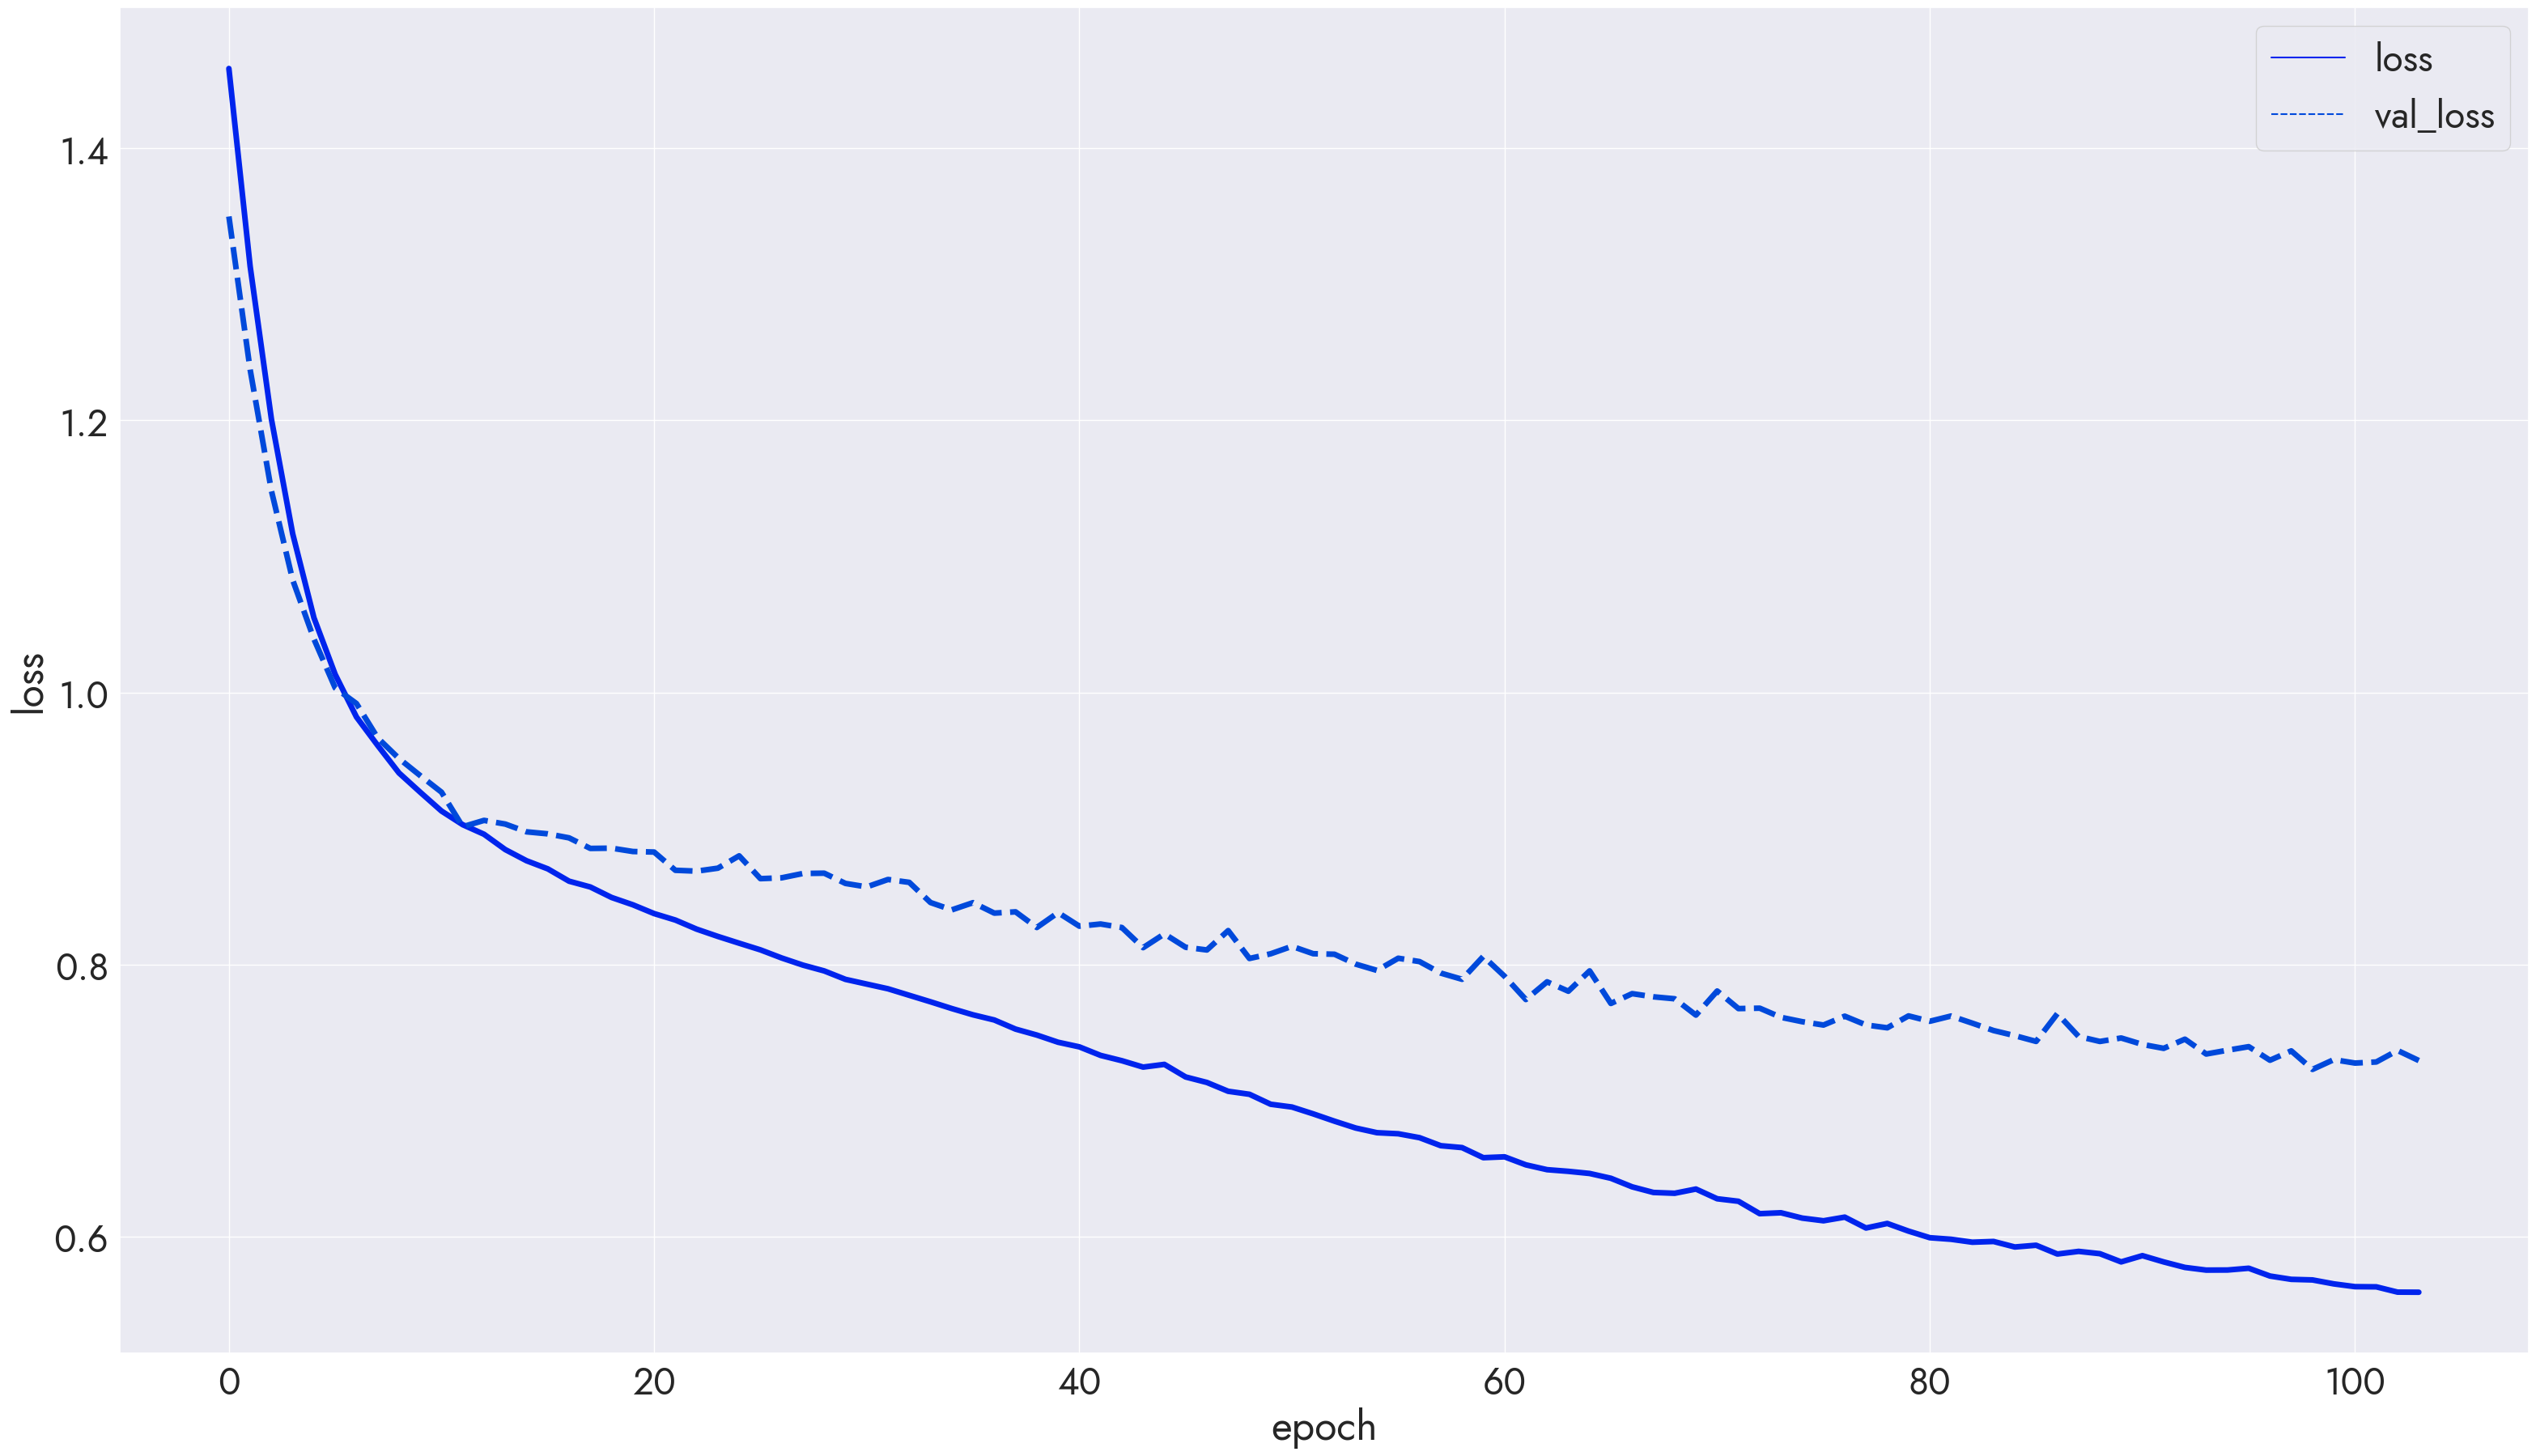

In [29]:
small_plot_history = sns.lineplot(data=pd.DataFrame(train_histories[small_model.name])[['loss', 'val_loss']], linewidth=5)

small_plot_history.set_xlabel('epoch')
small_plot_history.set_ylabel('loss');

In [30]:
small_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{small_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [31]:
small_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

19/19 - 0s - loss: 0.5921 - accuracy: 0.7368 - 167ms/epoch - 9ms/step


In [32]:
test_results[small_model.name] = small_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

5/5 - 0s - loss: 0.7177 - accuracy: 0.7105 - 40ms/epoch - 8ms/step


Сохраним модель:

In [33]:
small_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}_{small_model.name}')

INFO:tensorflow:Assets written to: model/light/fixed/fixed_small/assets


2023-05-31 19:33:20 - tensorflow - INFO - Assets written to: model/light/fixed/fixed_small/assets


### medium
Обучим модель, состоящую из трёх обучающих слоёв.

In [34]:
medium_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='medium'
)

In [35]:
train_histories[medium_model.name] = compile_and_fit(medium_model)

Model: "medium"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                896       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 5,343
Trainable params: 5,316
Non-trainable params: 27
_________________________________________________________

Визуализируем ход обучения:

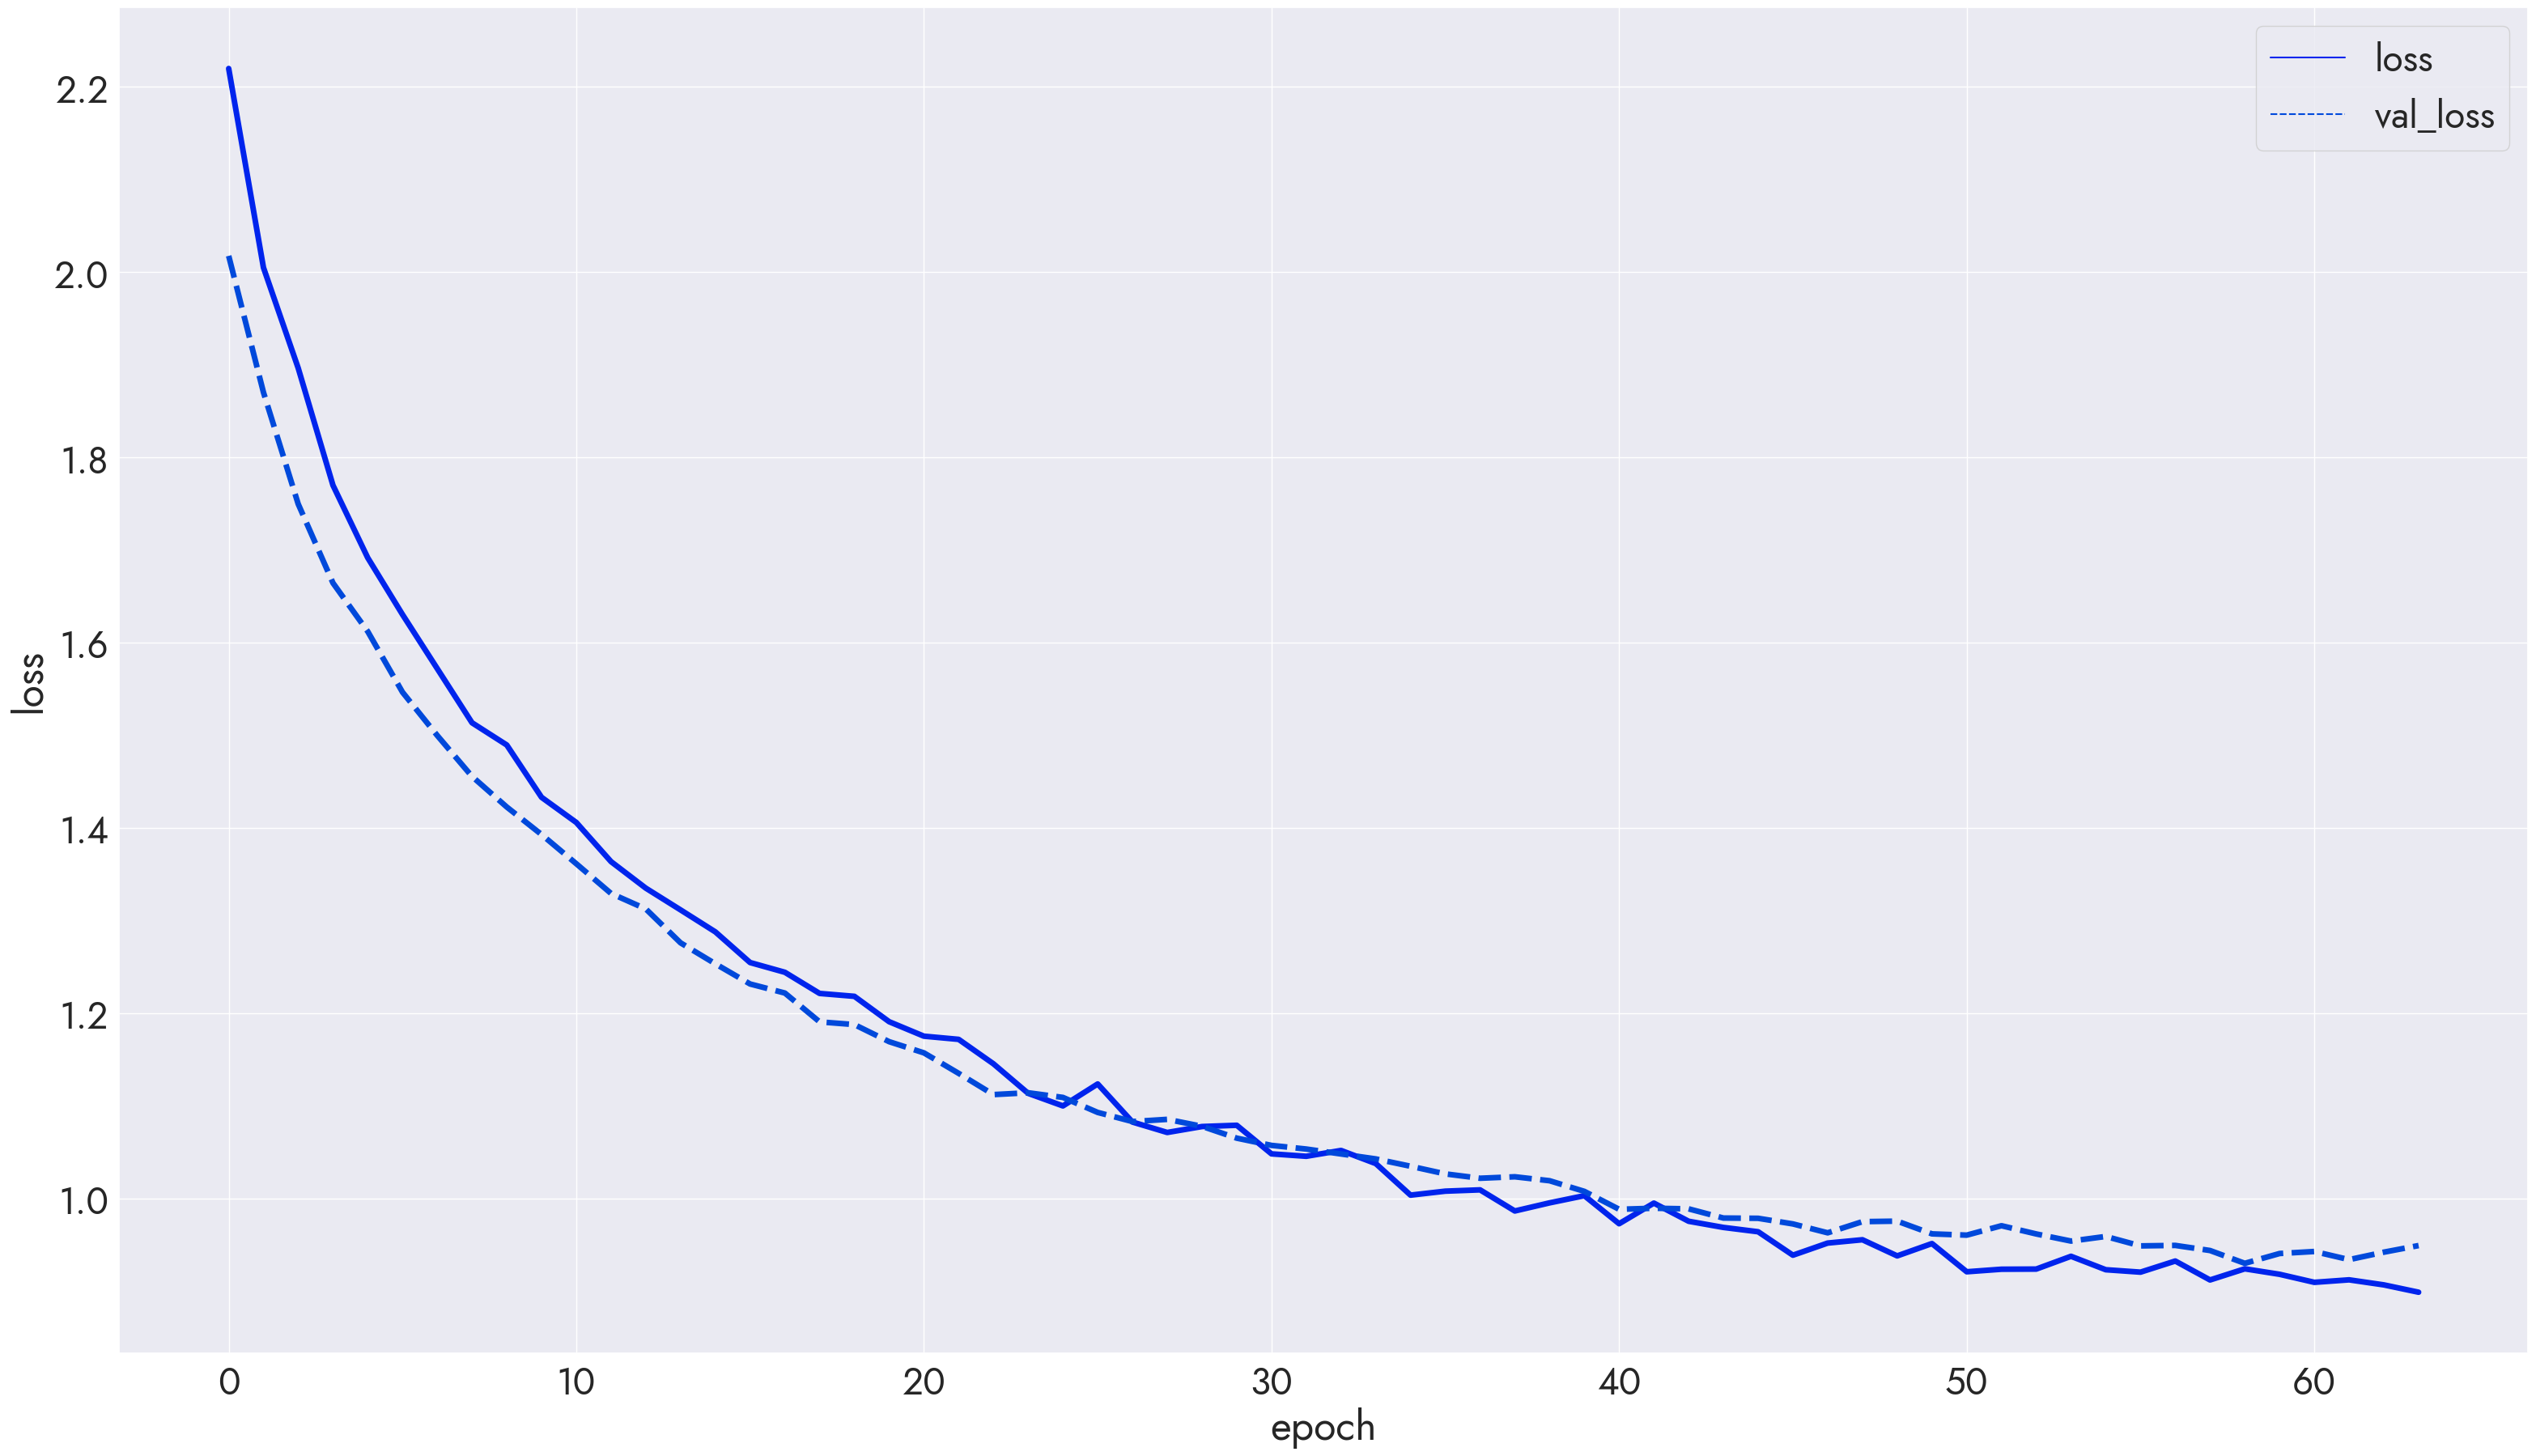

In [36]:
medium_plot_history = sns.lineplot(data=pd.DataFrame(train_histories[medium_model.name])[['loss', 'val_loss']], linewidth=5)

medium_plot_history.set_xlabel('epoch')
medium_plot_history.set_ylabel('loss');

In [37]:
medium_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{medium_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [38]:
medium_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

19/19 - 0s - loss: 0.8900 - accuracy: 0.6859 - 238ms/epoch - 13ms/step


In [39]:
test_results[medium_model.name] = medium_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

5/5 - 0s - loss: 0.9195 - accuracy: 0.7039 - 36ms/epoch - 7ms/step


Сохраним модель:

In [40]:
medium_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}_{medium_model.name}')

2023-05-31 19:33:34.053075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-05-31 19:33:34.219866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model/light/fixed/fixed_medium/assets


2023-05-31 19:33:34 - tensorflow - INFO - Assets written to: model/light/fixed/fixed_medium/assets


### large
Обучим модель, состоящую из шести обучающих слоёв.

In [41]:
large_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='large'
)

In [42]:
train_histories[large_model.name] = compile_and_fit(large_model)

Model: "large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_8 (Dense)             (None, 256)               3584      
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                             

Визуализируем ход обучения:

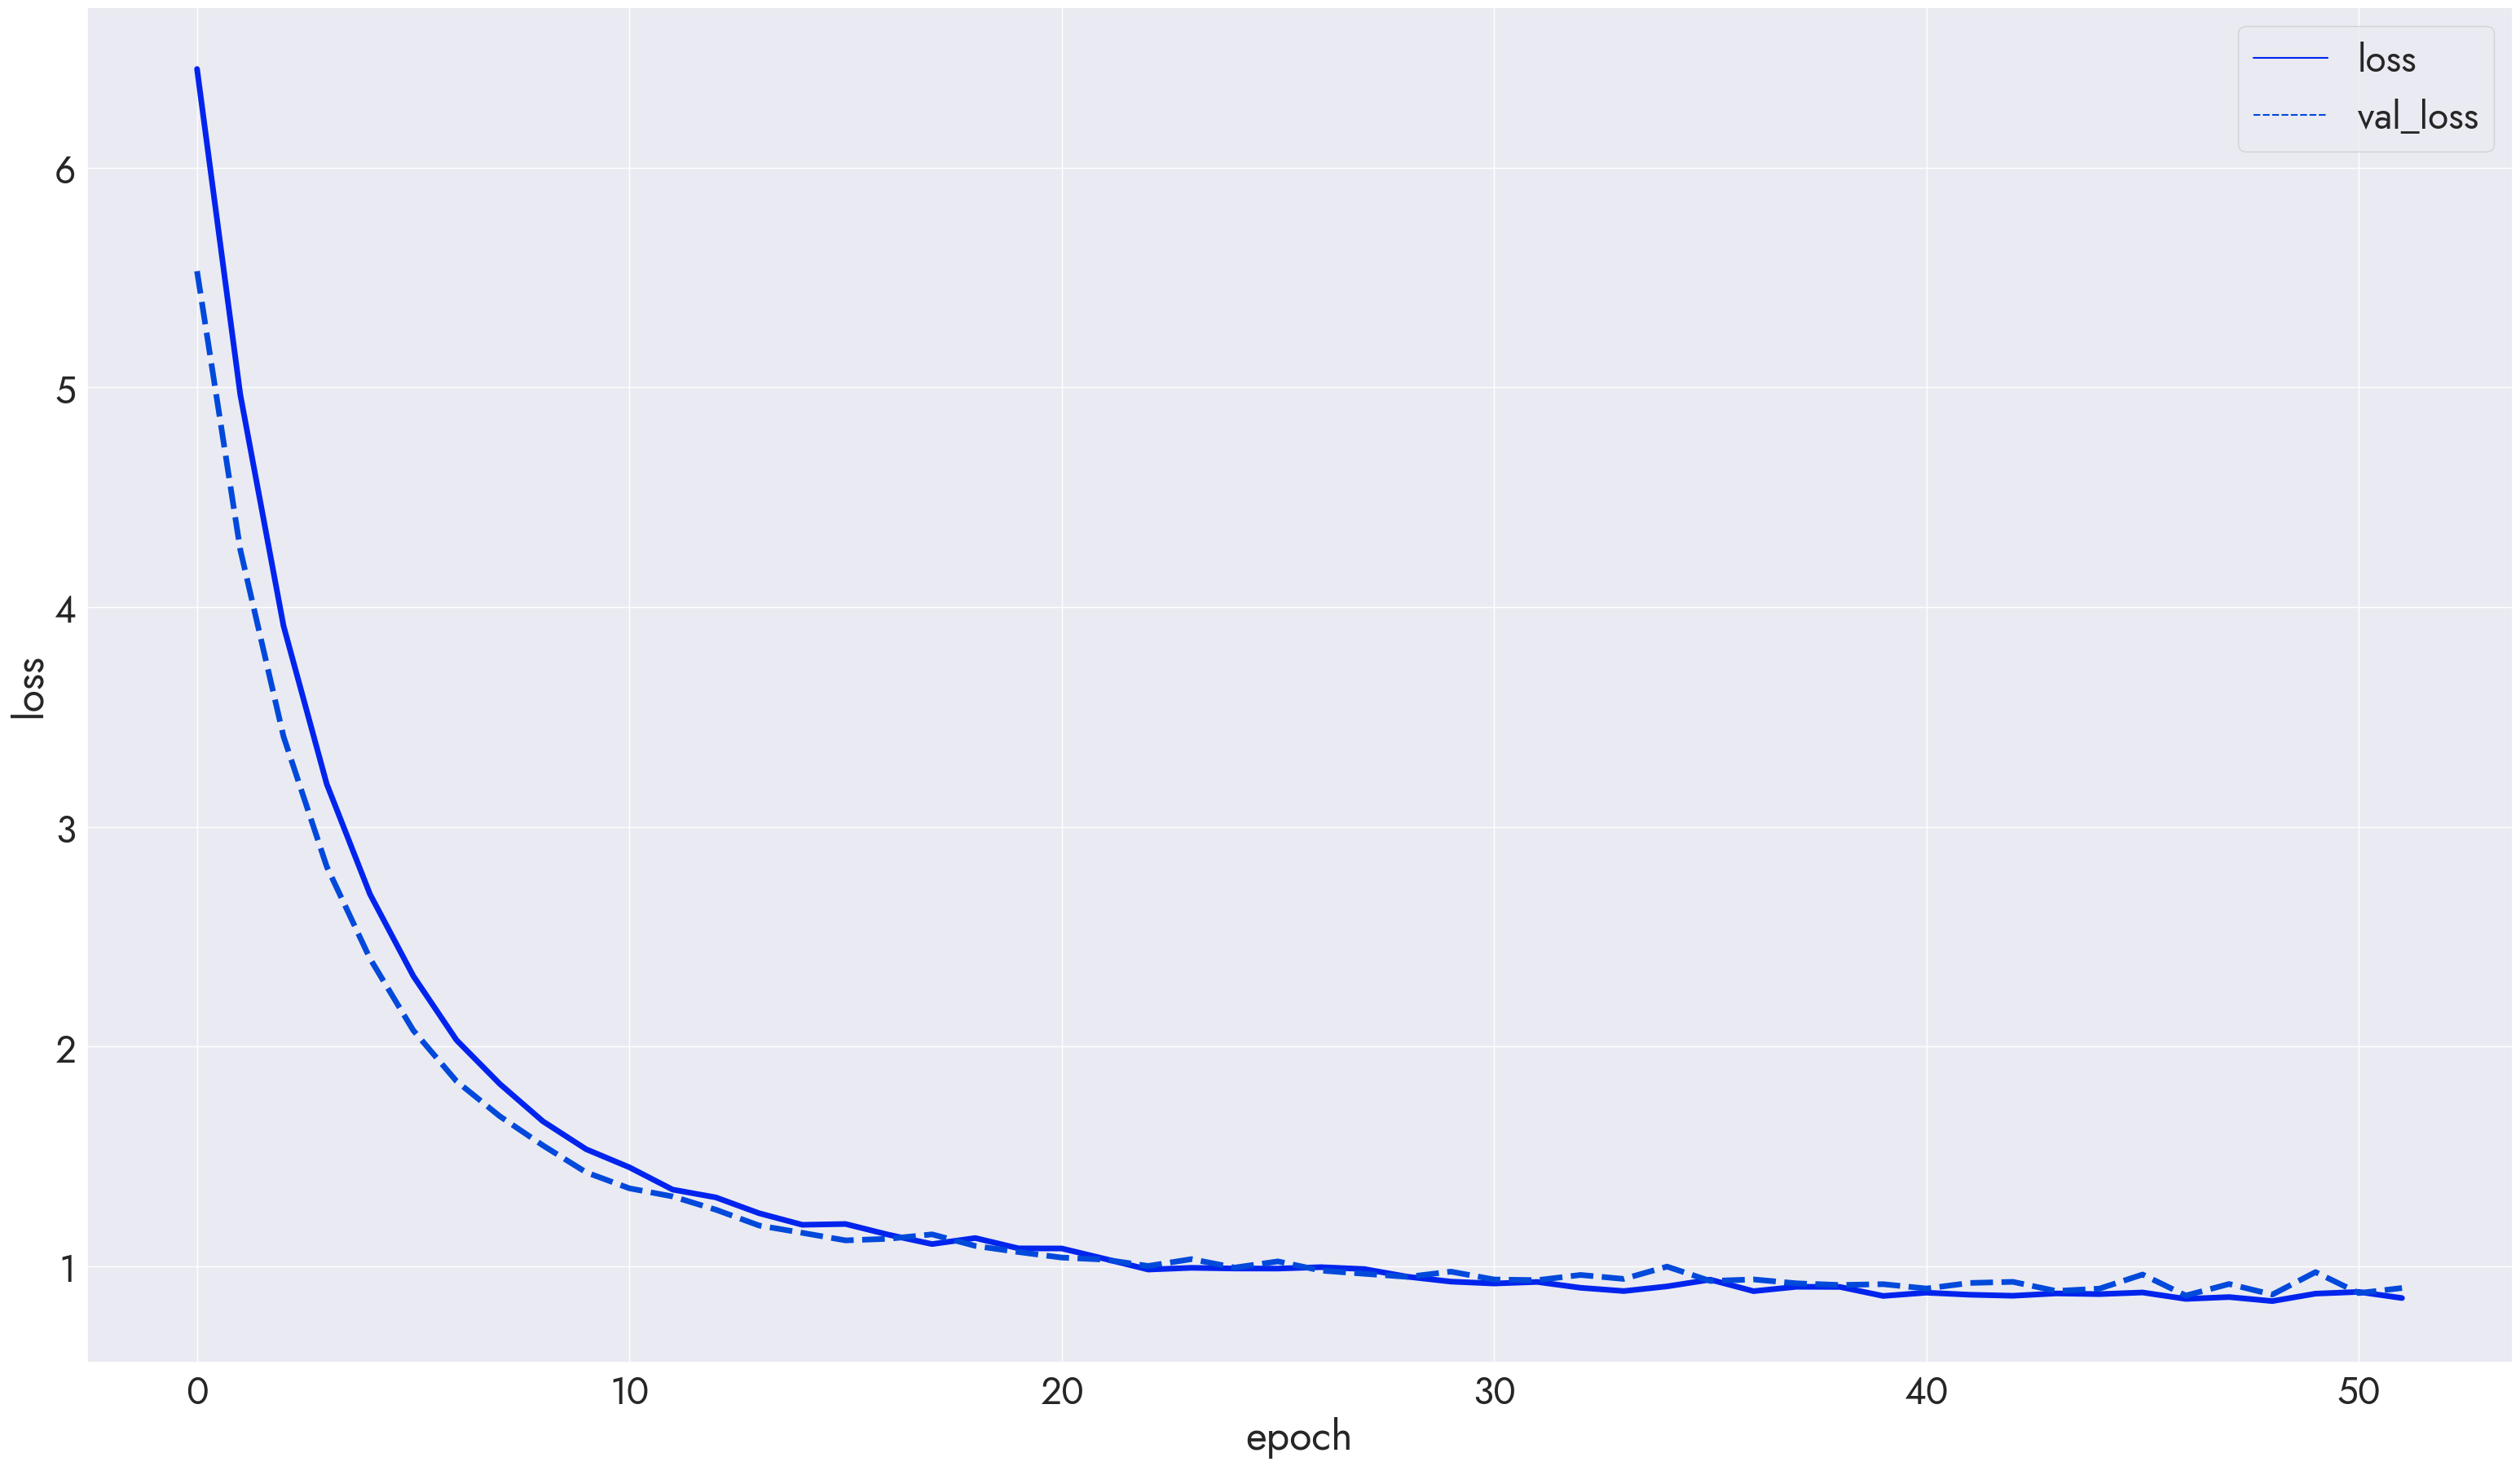

In [43]:
large_plot_history = sns.lineplot(data=pd.DataFrame(train_histories[large_model.name])[['loss', 'val_loss']], linewidth=5)

large_plot_history.set_xlabel('epoch')
large_plot_history.set_ylabel('loss');

In [44]:
large_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{large_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [45]:
large_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

19/19 - 0s - loss: 0.8084 - accuracy: 0.7270 - 131ms/epoch - 7ms/step


In [46]:
test_results[large_model.name] = large_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

5/5 - 0s - loss: 0.8870 - accuracy: 0.7500 - 53ms/epoch - 11ms/step


Сохраним модель:

In [47]:
large_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}_{large_model.name}')

2023-05-31 19:33:47.634268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-31 19:33:47.650649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-05-31 19:33:47.888849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-31 19:33

INFO:tensorflow:Assets written to: model/light/fixed/fixed_large/assets


2023-05-31 19:33:48 - tensorflow - INFO - Assets written to: model/light/fixed/fixed_large/assets


### finally
Выберем лучшую модель и проанализируем её предсказательные возможности.

Визуализируем график изменения точности предсказаний полученных моделей:

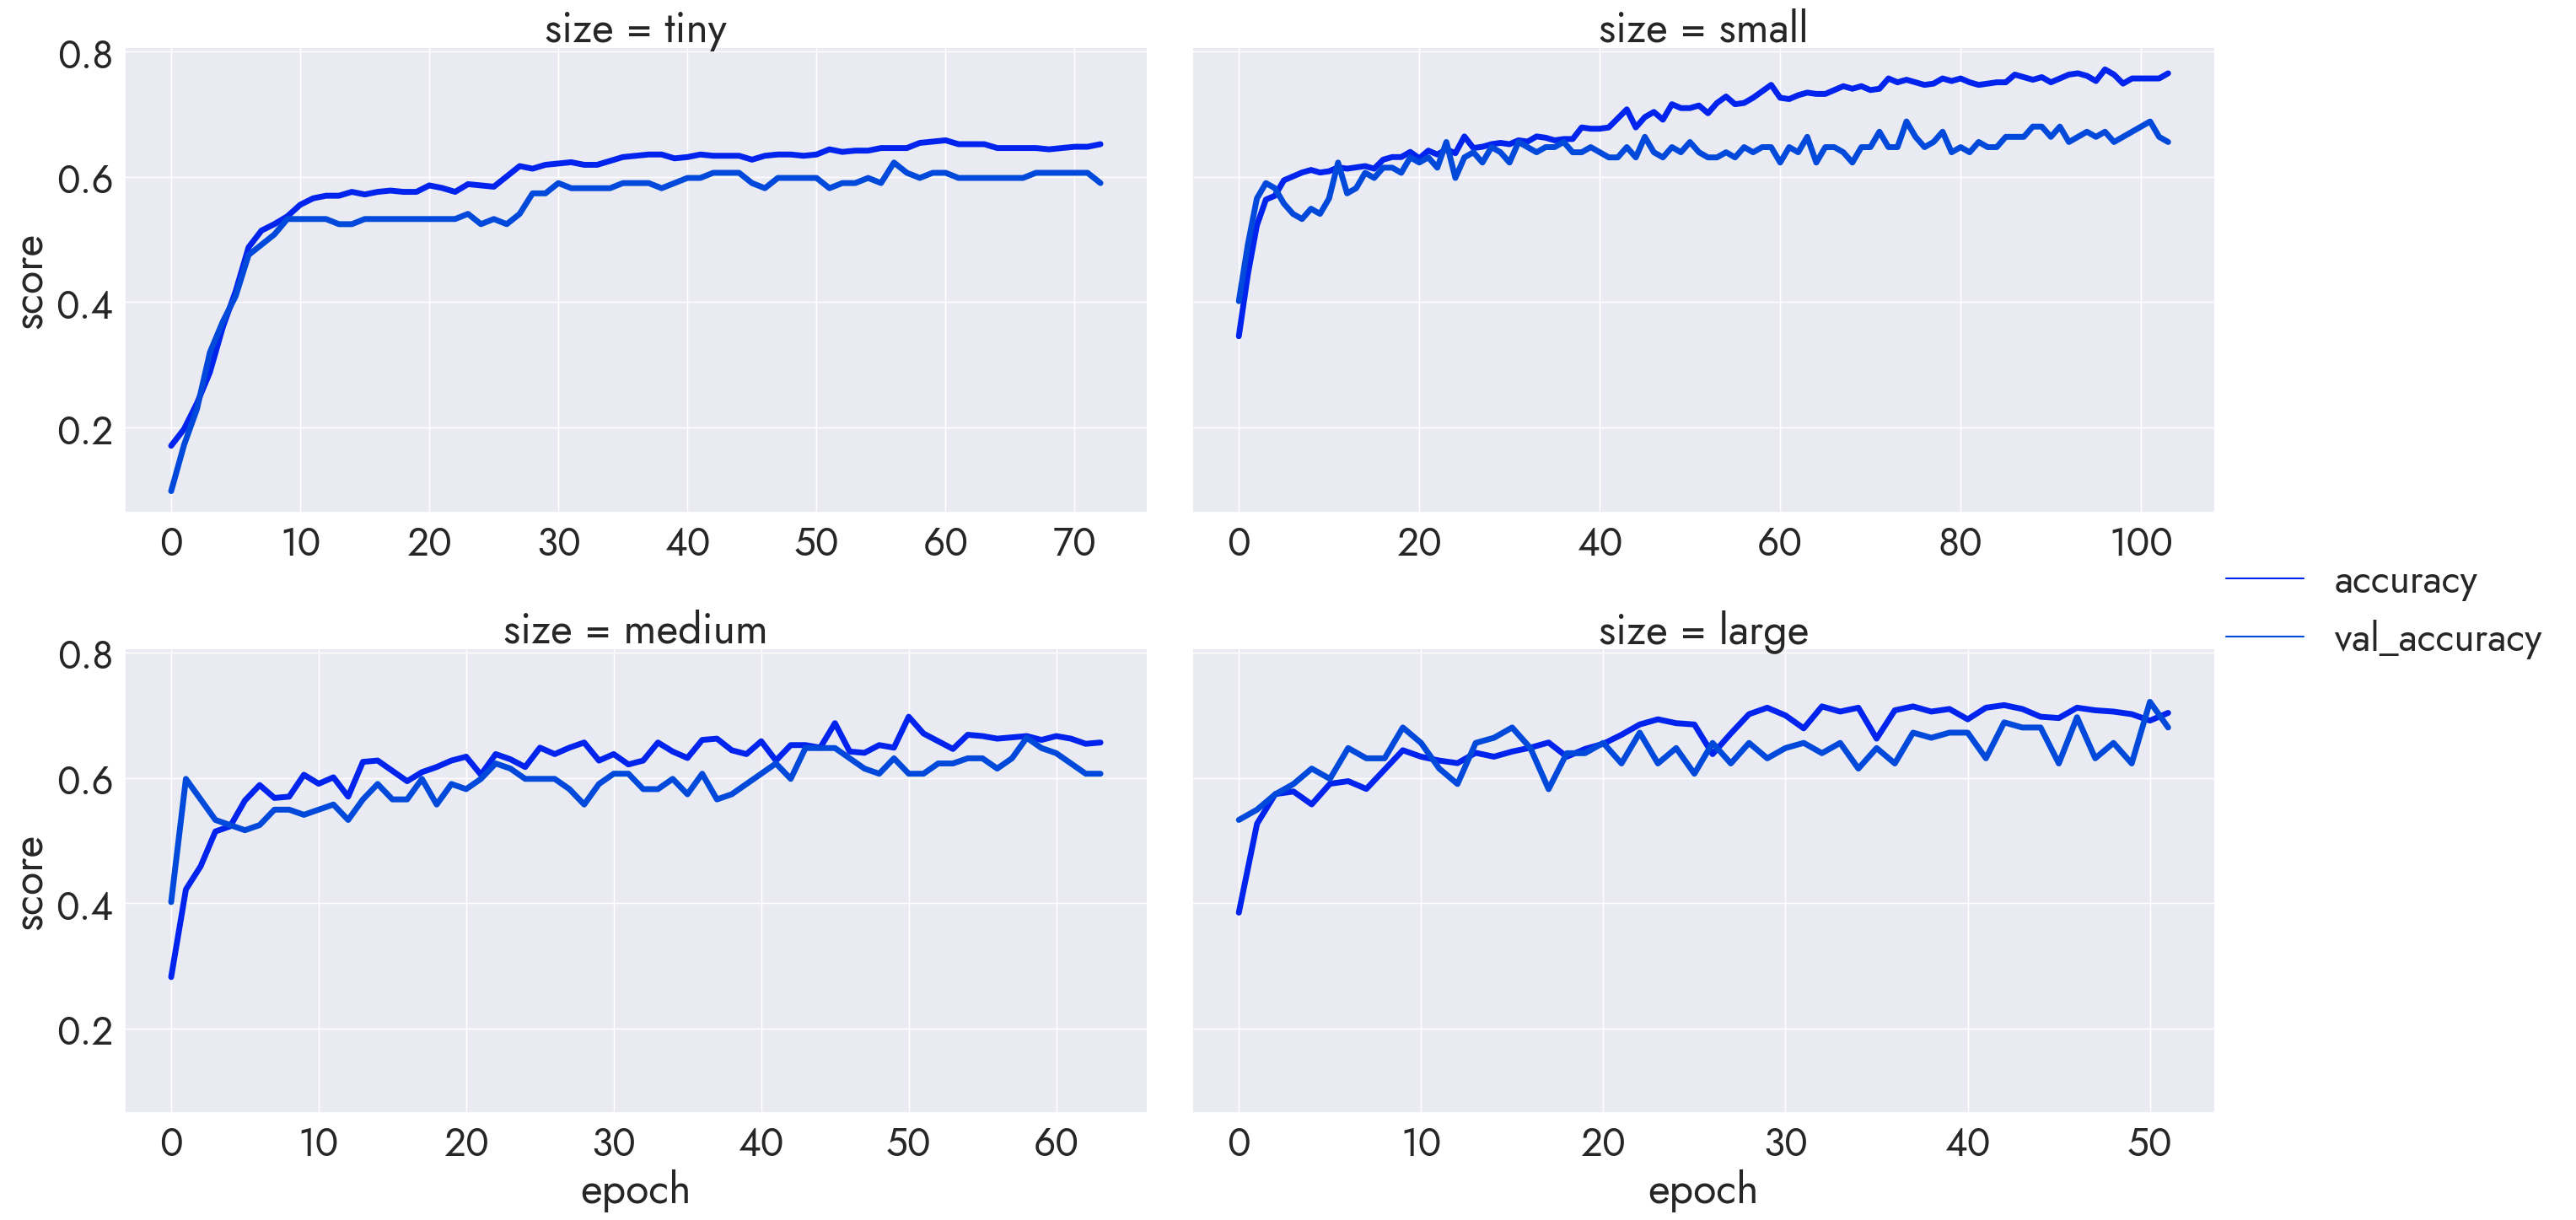

In [48]:
dnn_grid_history = sns.FacetGrid(
    data=(
        pd.concat(
            [pd.DataFrame(train_history)[['accuracy', 'val_accuracy']].stack() for train_history in train_histories.values()],
            keys=train_histories.keys(), names=['size', 'epoch', 'type'])
        .reset_index(level=['size'])
        .rename(columns={0: 'score'})
    ),
    col='size', col_wrap=2,
    height=FIG_SIZE[0] / 5, aspect=FIG_SIZE[0] / FIG_SIZE[1], sharex=False
)

dnn_grid_history.map_dataframe(sns.lineplot, 'epoch', 'score', hue='type', linewidth=5)
dnn_grid_history.add_legend();

In [49]:
dnn_grid_history.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_dnn.png', transparent=True)

Выберем в качестве основной модель с наибольшей точностью предсказаний:

In [50]:
dnn_model_results = pd.DataFrame(test_results, index=['test_loss', 'test_accuracy'])

dnn_model_results

,tiny,small,medium,large
test_loss,0.849113,0.717668,0.919454,0.886976
test_accuracy,0.671053,0.710526,0.703947,0.750000


In [51]:
dnn_model = large_model

С помощью данной модели предскажем результирующий показатель тестовой выборки:

In [52]:
test_predict = dnn_model.predict(test_features, batch_size=BATCH_SIZE, verbose=2);

5/5 - 0s - 94ms/epoch - 19ms/step


Массив предсказанных значений состоит из весов, с каким шансом к какой группе относится конкретное наблюдение.
Конвертируем его в вид dummy-переменных:

In [53]:
test_predict = np.where(test_predict == test_predict.max(axis=1).reshape(-1, 1), 1, 0)

Рассмотрим распределение предсказаний модели по группам:

In [54]:
from sklearn.metrics import confusion_matrix

dnn_dist = pd.DataFrame(confusion_matrix(test_df['group'], pd.from_dummies(pd.DataFrame(test_predict)).astype('int8')),
                        index=groups, columns=groups)
dnn_dist

,Low income,Lower-middle income,Upper-middle income,High income
Low income,38,5,0,0
Lower-middle income,12,19,1,2
Upper-middle income,8,6,22,3
High income,0,1,0,35


Выведем данную таблицу на тепловую карту:

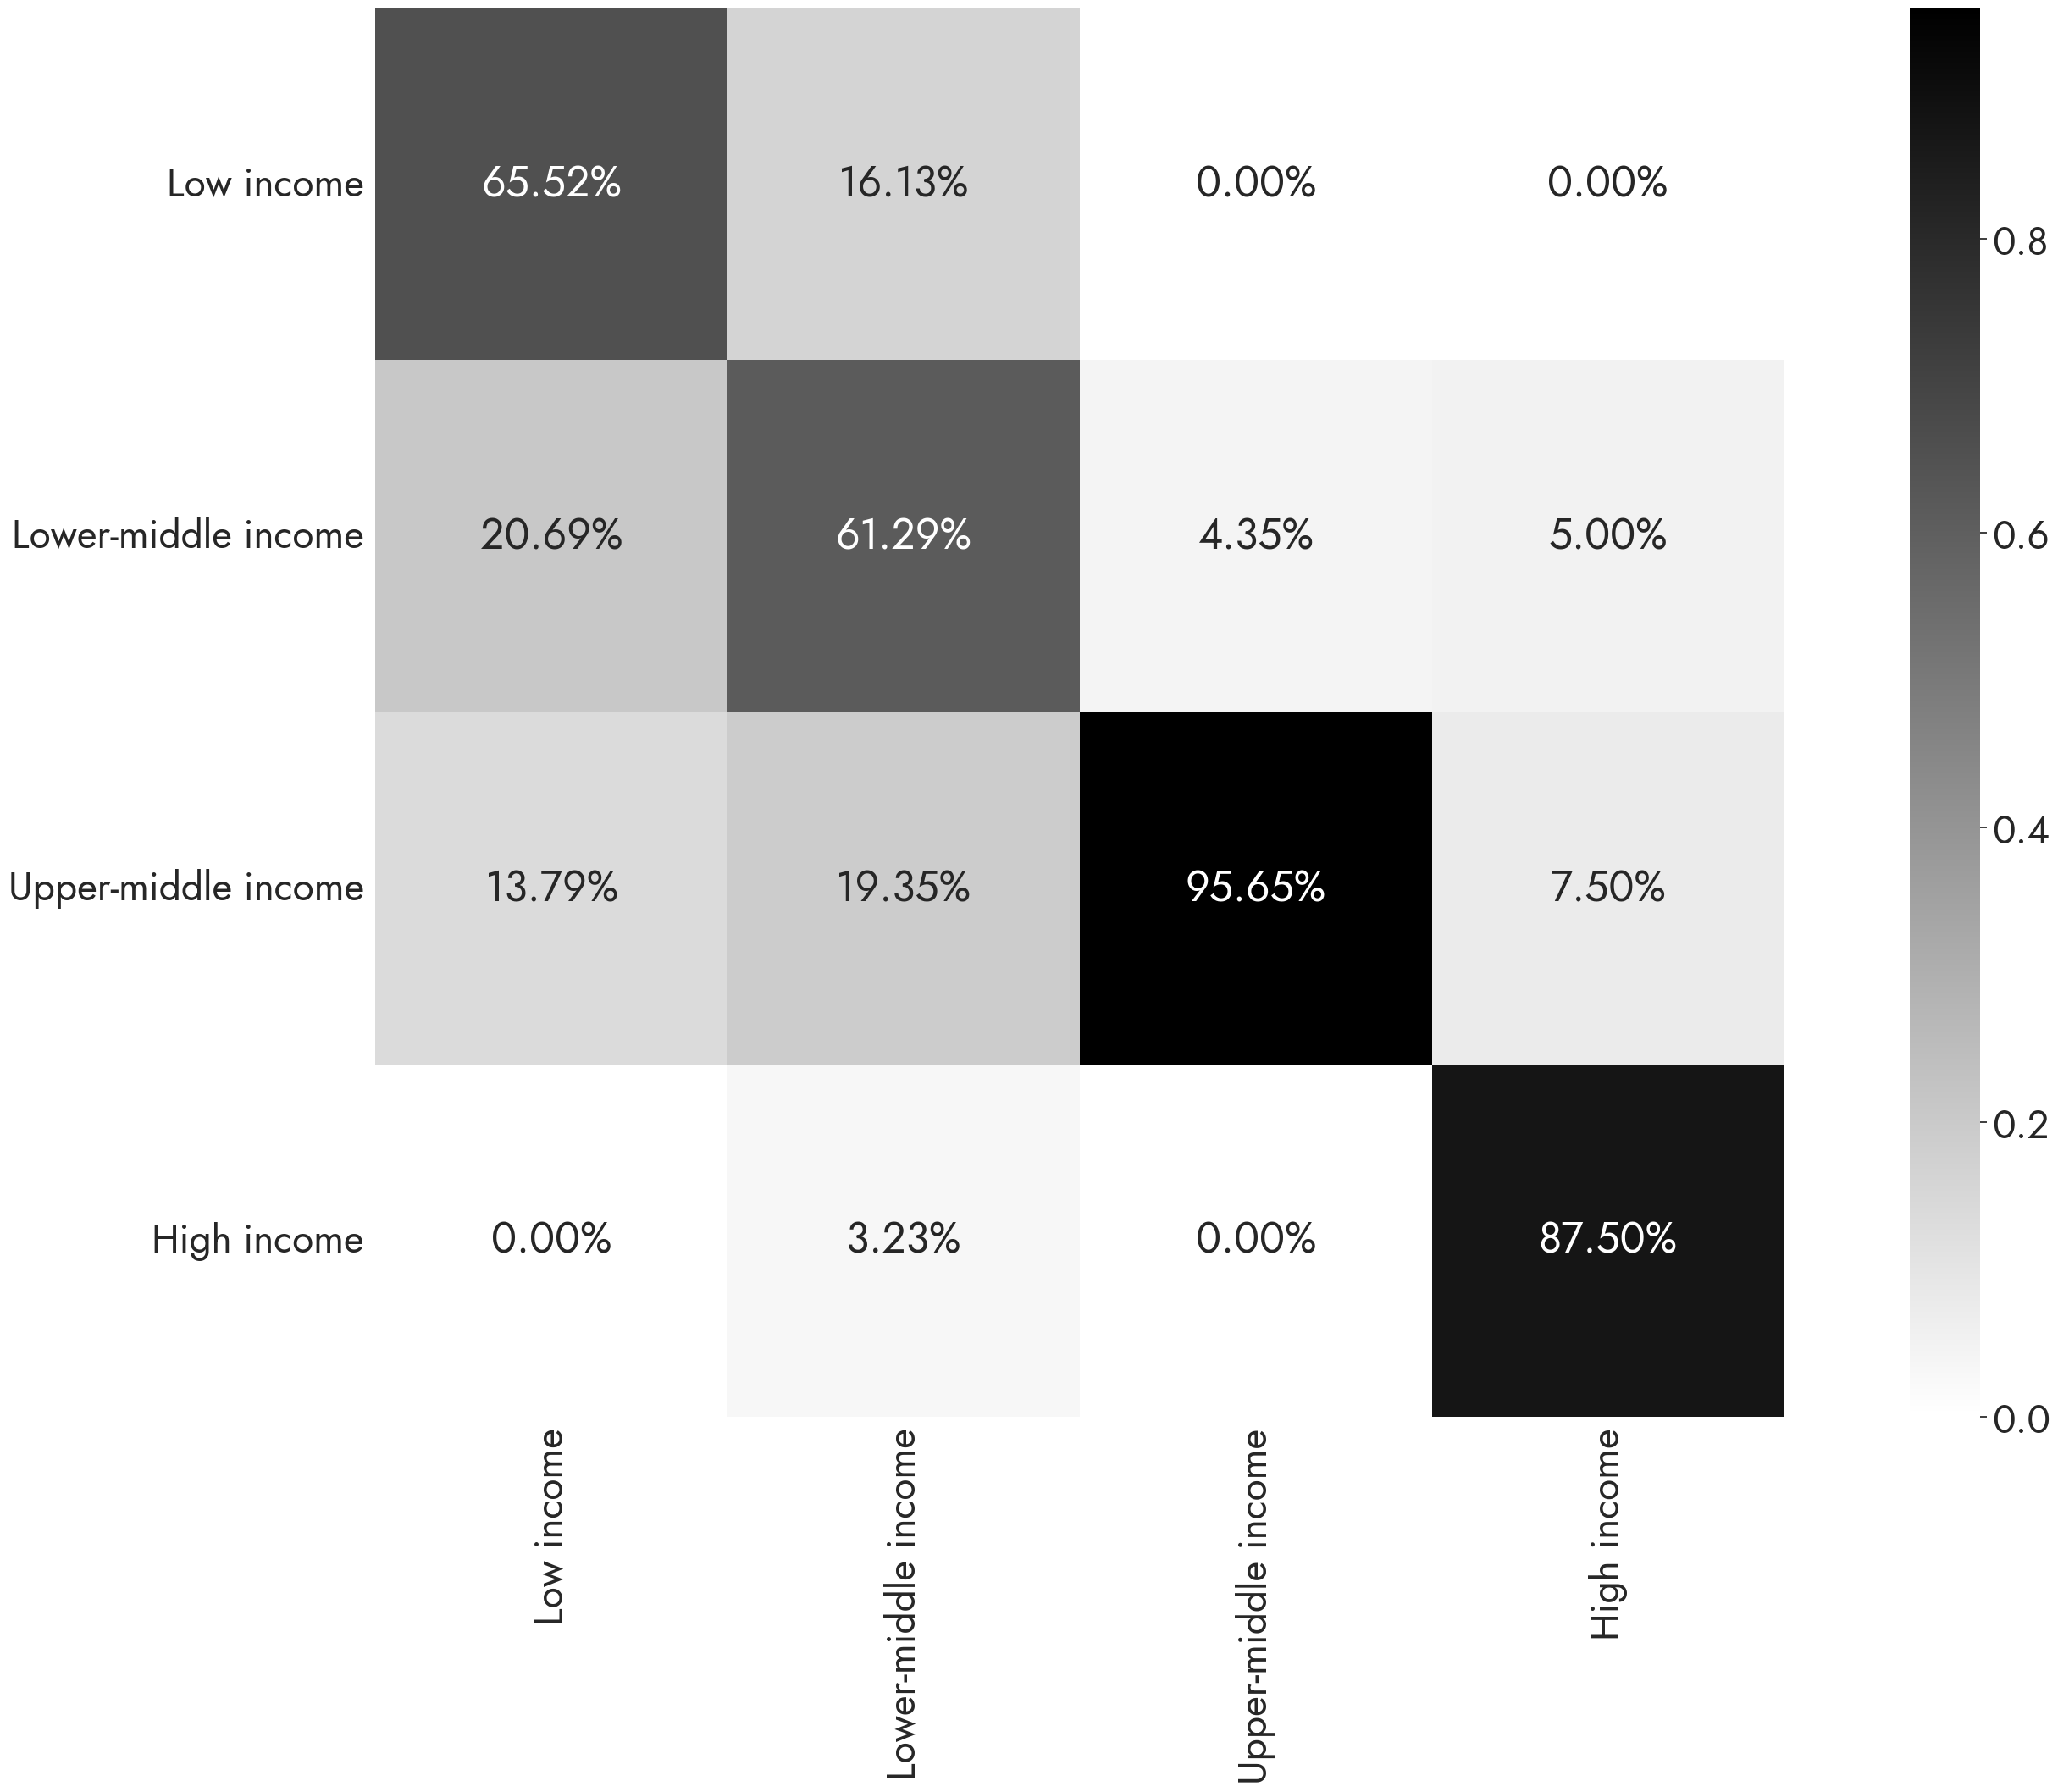

In [55]:
dnn_plot_dist = sns.heatmap(dnn_dist / dnn_dist.sum(), cmap='gray_r', annot=True, fmt='.2%', square=True)

dnn_plot_dist.set_xlabel(None);

In [56]:
dnn_plot_dist.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_dist_dnn.png', transparent=True)

Как видно по сводной таблице и по графику, в большинстве случаев модель верно определяет группу.
Визуализируем распределение ошибок в модели:

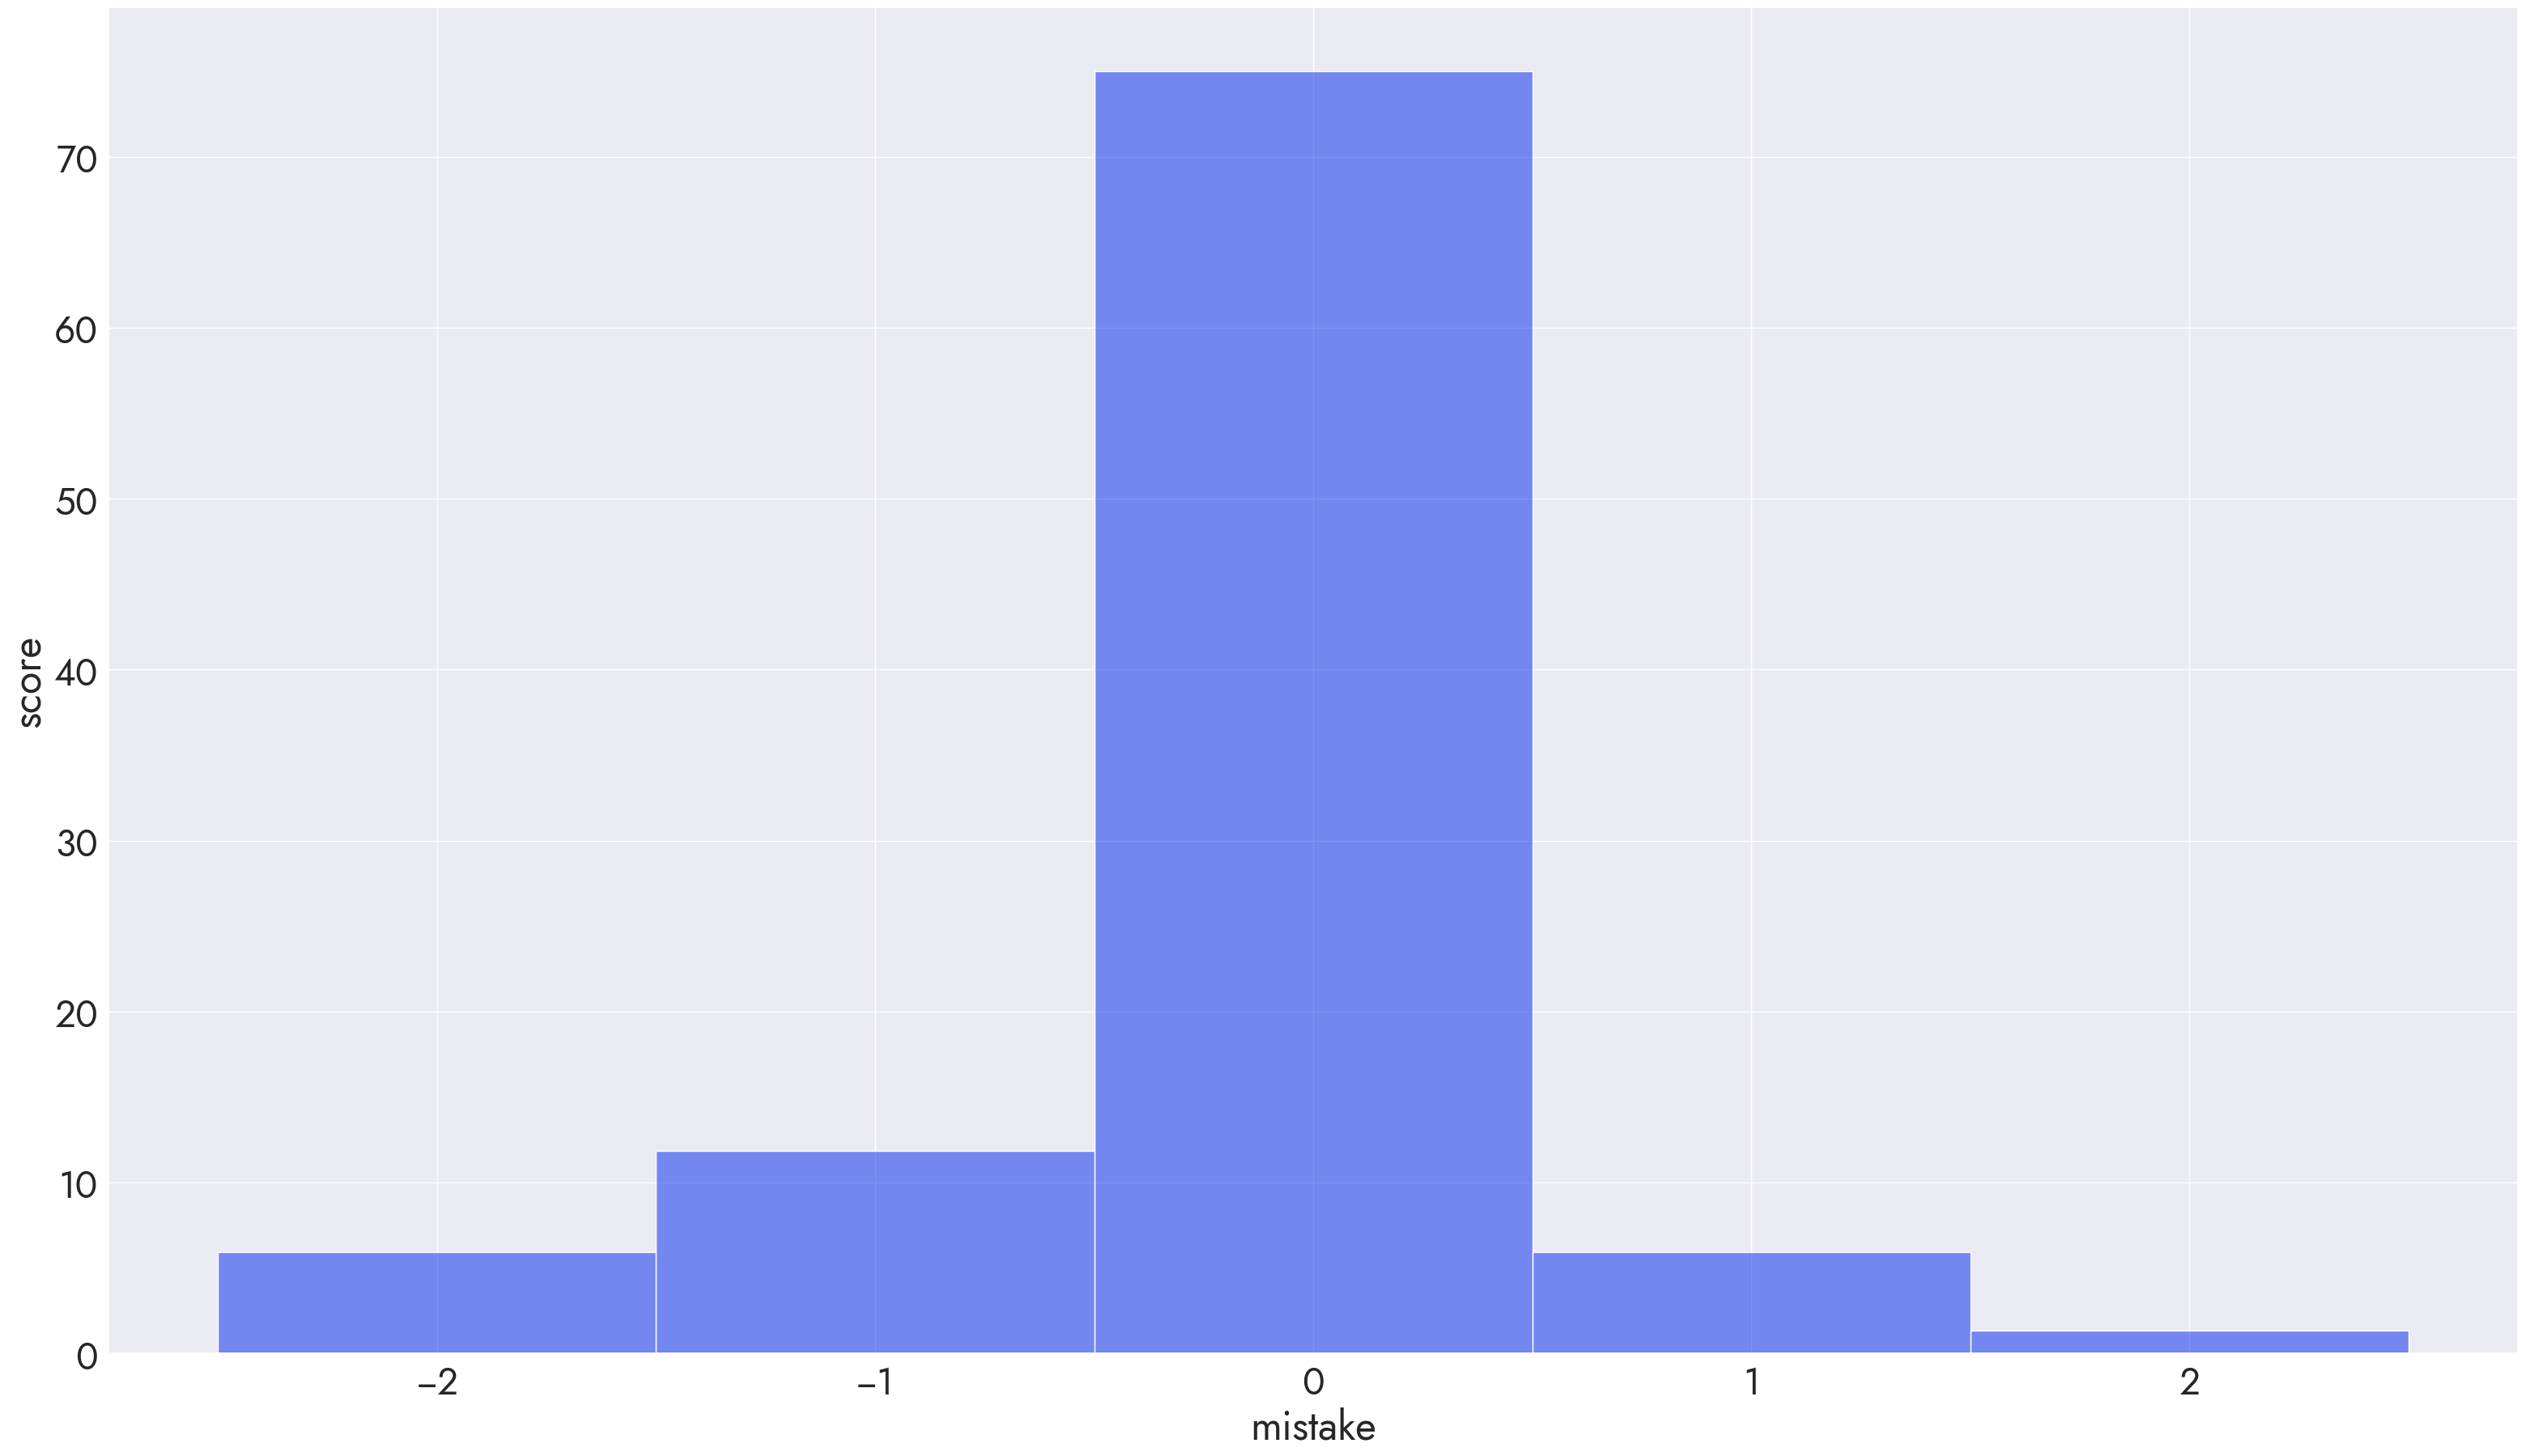

In [57]:
dnn_plot_mistakes = sns.histplot(data=pd.from_dummies(pd.DataFrame(test_predict)) - pd.from_dummies(pd.DataFrame(test_target)),
                                 stat='percent', legend=False, discrete=True)

dnn_plot_mistakes.set_xlabel('mistake')
dnn_plot_mistakes.set_ylabel('score');

In [58]:
dnn_plot_mistakes.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_mistakes_dnn.png', transparent=True)

Большинство наблюдений было предсказано правильно - при этом распределение ошибок имеет нормальный вид, в среднем модель ошибается в рамках соседних групп.